# **1. Image Folder Review & Cleaning**

DONE

# **2. Clone PyTorch & Install Necessary Packages**

# **3. Imports**

In [1]:
import sys
sys.path.append('./vision/references/detection/')

In [2]:
# Src: 
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot
import seaborn as sns
from PIL import Image
from glob import glob
import os
import random
import cv2
import xml.etree.ElementTree as ET

import torch
import torchvision
import pycocotools
from engine import train_one_epoch, evaluate

# **4. Settings**

Notebook Color Scheme:


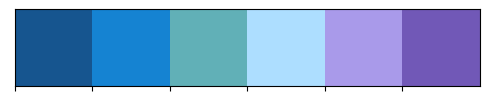

In [3]:
import matplotlib as mpl
# Custom colors
class color:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'
# Set Matplotlib graph colors
my_colors = ["#16558F", "#1583D2", "#61B0B7", "#ADDEFF", "#A99AEA", "#7158B7"]
print(color.S+"Notebook Color Scheme:")
sns.palplot(sns.color_palette(my_colors))
plt.show() 
# Set Matplotlib graph settings
sns.set_style("white")
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.rcParams.update({'font.size': 14})

# **5. Data Exploration**

In [4]:
dir1 = '../../datasets/TMMT Hubnut Object Detection Dataset'

Total Number of images: 1334


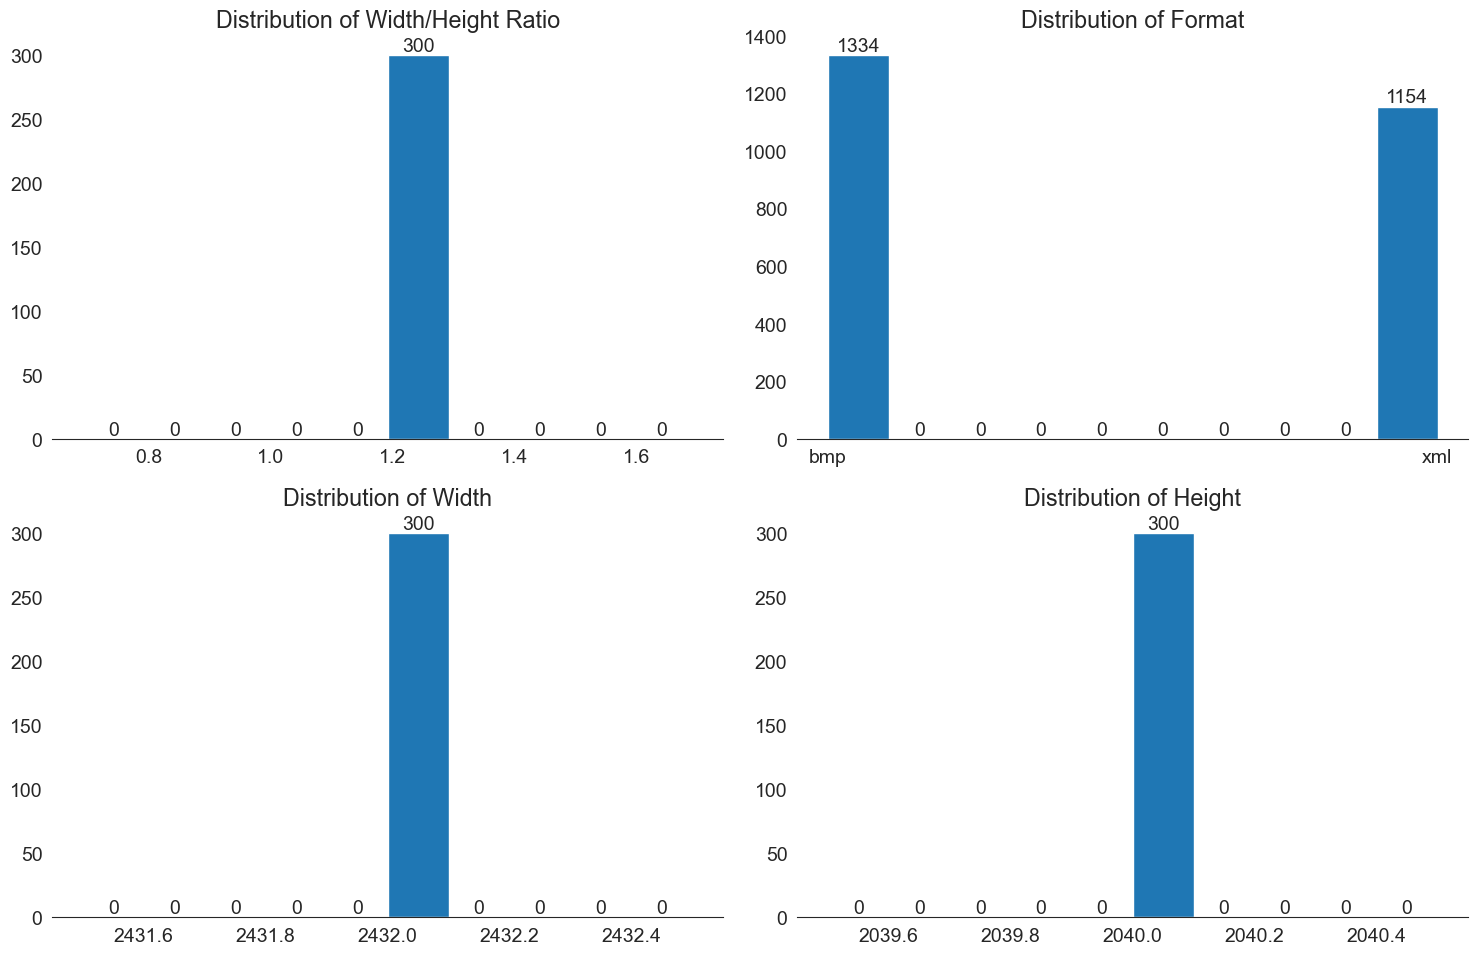

In [5]:
def plot_summary_graphs(*dir, num_samples=500):
    graph_list = {"Width/Height Ratio":[],"Format":[],"Width":[],"Height":[]}
    directories = [*dir]
    images = sum([glob(os.path.join(i,j), recursive=True) for j in ("**/*.png","**/*.jpg","**/*.jpeg","**/*.bmp") for i in directories],[])
    all_files = sum([glob(os.path.join(i,'**/*.*'), recursive=True) for i in directories],[])
    graph_list["Format"] = [fp.split('.')[-1] for fp in all_files]
    print('Total Number of images: %d'%len(images))
    samples = images if num_samples==0 else random.sample(images, num_samples)
    for image in samples:
        im = Image.open(image)
        graph_list["Width"].append(im.size[0])
        graph_list["Height"].append(im.size[1])
        graph_list["Width/Height Ratio"].append(im.size[0]/im.size[1])
    plt.figure(figsize=(15,10))
    for i,k in enumerate(graph_list):
        plt.subplot(2, 2, i+1)
        # ax = sns.countplot(x=graph_list[k])
        # ax.bar_label(ax.containers[0])
        counts, edges, bars = plt.hist(graph_list[k], align="mid")
        plt.bar_label(bars)
        # plt.hist(graph_list[k], histtype='stepfilled', align='mid')
        plt.title('Distribution of '+ k)
    plt.tight_layout()
    plt.ticklabel_format(useOffset=False) # Prevents scientific notation (e.g 1.28e3) 
    plt.show()

# set num_samples to 0 to check all dir
plot_summary_graphs(dir1, num_samples=300)

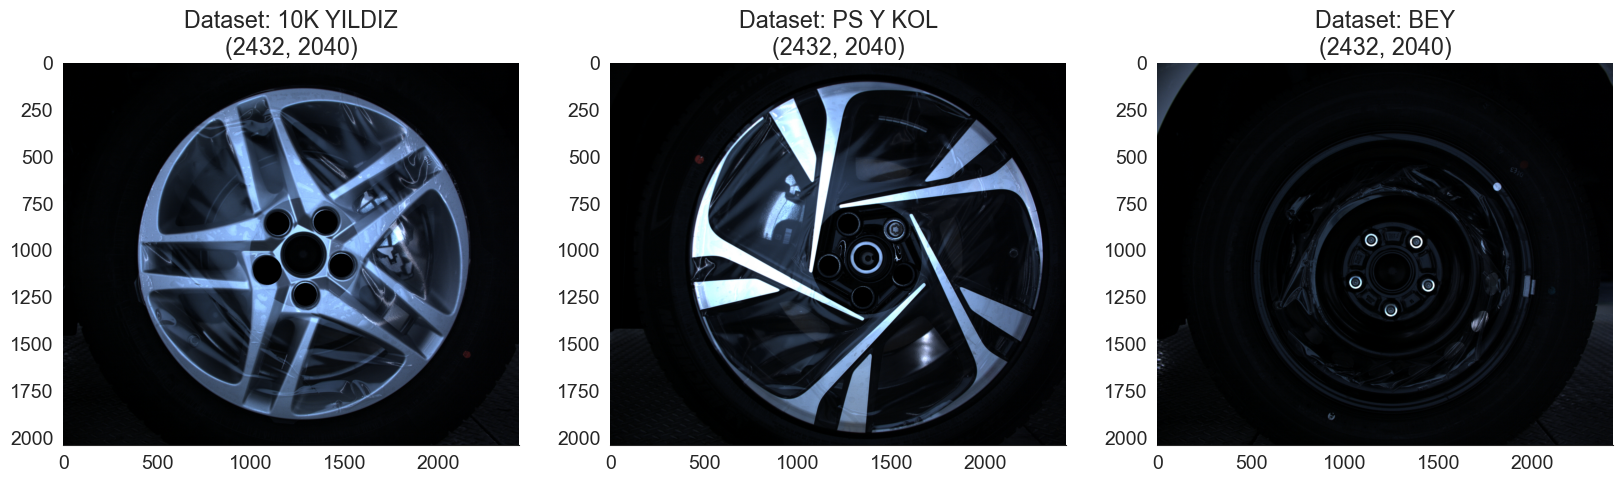

In [6]:
def plot_images_dirs(*dir, num_samples=5, num_cols=5, plot_gap=6):     
    directories = [*dir]
    images = sum([glob(os.path.join(i,j), recursive=True) for j in ("**/*.png","**/*.jpg","**/*.jpeg","**/*.bmp") for i in directories],[])
    samples = images if num_samples==0 else random.sample(images, num_samples)
    fig = plt.figure(figsize=(20,num_samples/num_cols*plot_gap)) 
    for i,image in enumerate(samples):
        plt.subplot(round(num_samples/num_cols),num_cols,i+1)
        img = Image.open(image)
        plt.title("Dataset: " + image.split("\\")[-2] + "\n" + str(img.size))
        plt.imshow(img)
    plt.show()

plot_images_dirs(dir1, num_samples=3, num_cols=3, plot_gap=6)

In [7]:
batch_size = 8
seed = 10
img_size=(224,224)

# **6. Loading Data**

In [8]:
import xml.etree.ElementTree as ET 
def xmls2df(*xmls_dir, bbox_format="yolo"):
    directories = [*xmls_dir]
    xmls = sum([glob(os.path.join(i,'**/*.xml'), recursive=True) for i in directories], [])
    images = sum([glob(os.path.join(i,j), recursive=True) for j in ("**/*.png","**/*.jpg","**/*.jpeg","**/*.bmp") for i in directories],[]) 
    d_dict = dict(file_name=[],image_path=[],label=[],bboxes=[]) 
    for image in images: 
        xml_path = sum([glob(os.path.join(i,'**/',os.path.split(image)[1].split(".")[0]+'.xml'), recursive=True) for i in directories],[]) 
        if len(xml_path) == 1: # If xml file (annotations) exist for that image, load annotations 
            xml_path = xml_path[0] 
            root = ET.parse(xml_path).getroot() # This line same for all formats, start from here  
            file_name = root.find("filename").text  
            width = int(root.find("size").find("width").text)  
            height = int(root.find("size").find("height").text)  
            objects = root.findall('object') 
            annots,labels = [],[] 
            if len(objects) > 0: 
                for i,k in enumerate(objects): 
                    if objects[i].find("name").text != 'OK DS NUT': # TO EXCLUDE SOME CLASS WHILE LOADING 
                        class_name = objects[i].find("name").text 
                        labels.append(class_name) 
                        labels_info = objects[i].find('bndbox') 
                        xmin = float(labels_info.find('xmin').text) 
                        ymin = float(labels_info.find('ymin').text) 
                        xmax = float(labels_info.find('xmax').text) 
                        ymax = float(labels_info.find('ymax').text) 
                        if bbox_format == "pascal_voc": 
                            annots.extend([[xmin, ymin, xmax, ymax]]) 
                        elif bbox_format == "yolo": 
                            annots.extend([[(xmin+(xmax-xmin)/2)/width, (ymin+(ymax-ymin)/2)/height, (xmax-xmin)/width, (ymax-ymin)/height]]) 
                        elif bbox_format == "albumentations": 
                            annots.extend([[xmin/width, ymin/height, xmax/width, ymax/height]]) 
                d_dict["file_name"].append(file_name) 
                d_dict["image_path"].append(image) 
                d_dict["label"].append(labels) 
                d_dict["bboxes"].append(annots) 
            else: # if xml file not exist without any annotations, load only image 
                d_dict["file_name"].append(os.path.split(image)[1]) 
                d_dict["image_path"].append(image) 
                d_dict["label"].append([]) 
                d_dict["bboxes"].append([]) 
        else: # if xml file not exist for that image (image w/o annotations), load only image 
            d_dict["file_name"].append(os.path.split(image)[1]) 
            d_dict["image_path"].append(image) 
            d_dict["label"].append([]) 
            d_dict["bboxes"].append([]) 
    df = pd.DataFrame(d_dict) 
    return df 

df = xmls2df(dir1, bbox_format="pascal_voc")

# **7. Merging Separate Sets**

Already done.

# **8. Data Cleaning**

In [9]:
# Check duplicate values
df.duplicated(subset=['file_name']).any()

False

In [10]:
# Check NA values
df.isna().any().any()

False

# **9. Target / Label / Feature Formatting**

In [11]:
classes = sorted(list({x for l in df["label"] for x in l}))
classes.insert(0, "BG")
print(classes)

['BG', 'NORMAL NUT', 'PARLAK KLT NUT', 'PARLAK NUT', 'SIYAH KLT NUT', 'SIYAH NUT', 'YUVARLAK NUT']


In [12]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 
le.fit(classes) 
df['class'] = df["label"].apply(lambda x: le.transform(x))

In [13]:
#Save label incoder for inference
import joblib
joblib.dump(le, "Hubnut_Detection_FasterRCNN_Label_Encoder.joblib") # ohe | le | lb | classes(manual method)

['Hubnut_Detection_FasterRCNN_Label_Encoder.joblib']

# **10. Exploratory Data Analysis (EDA)**

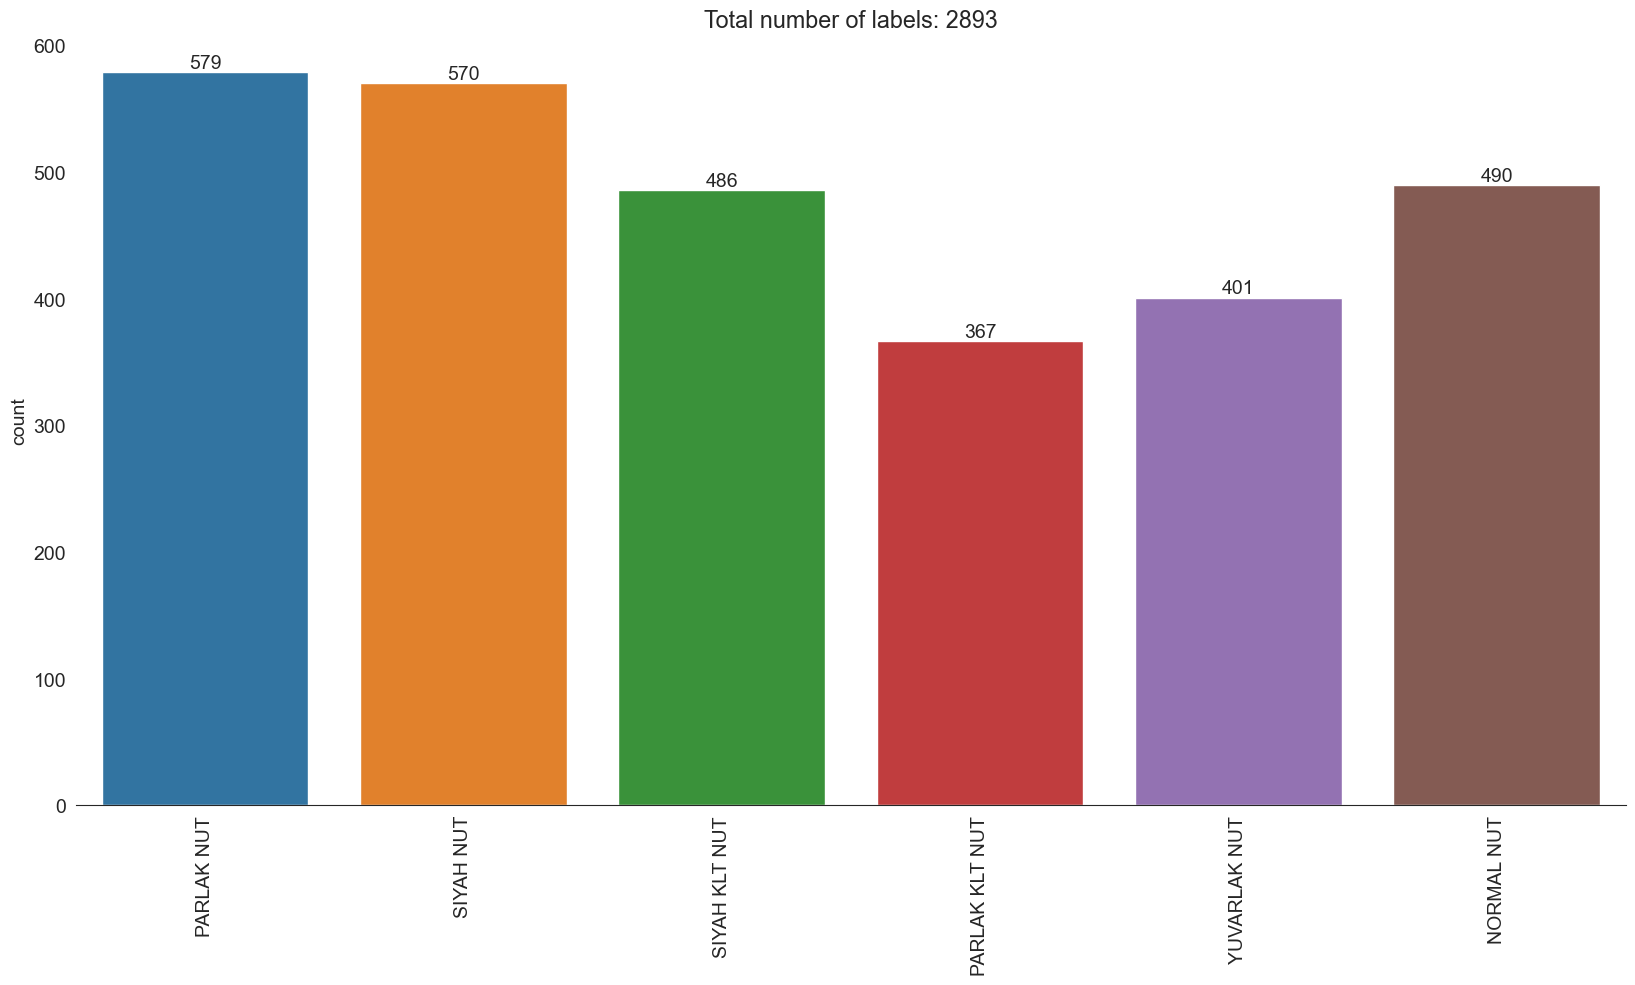

In [14]:
def plot_class_dist(*class_labels):   
    """ 
    Plot class distribution 
    class_labels: list or series of class labels 
    """ 
    fig = plt.figure(figsize=(20, 10)) 
    gs = fig.add_gridspec(len(class_labels),1) # Create subplots & specify (#rows, #columns) 
    gs.update(wspace=0.2, hspace=0.2) # Specify spaces between subplot (#rows, #columns) 
    for i in range(len(class_labels)): 
        ax = fig.add_subplot(gs[i, 0]) # Place plot on a subplot [row,column] 
        ax = sns.countplot(x=class_labels[i]) # For Array, use x=y, to change orientation: "x=" → "y=" 
        #ax.ticklabel_format(style='plain') # Prevent scientific notation  
        ax.bar_label(ax.containers[0]) # Show number on top of bars 
        ax.title.set_text(f"Total number of labels: {len(class_labels[i])}") 
        dummy = ax.set_xticklabels(ax.get_xticklabels(), rotation=90) #If you have too much class, rotates x labels 

plot_class_dist([df["label"][i][j] for i in range(len(df["label"])) for j in range(len(df["label"][i]))])

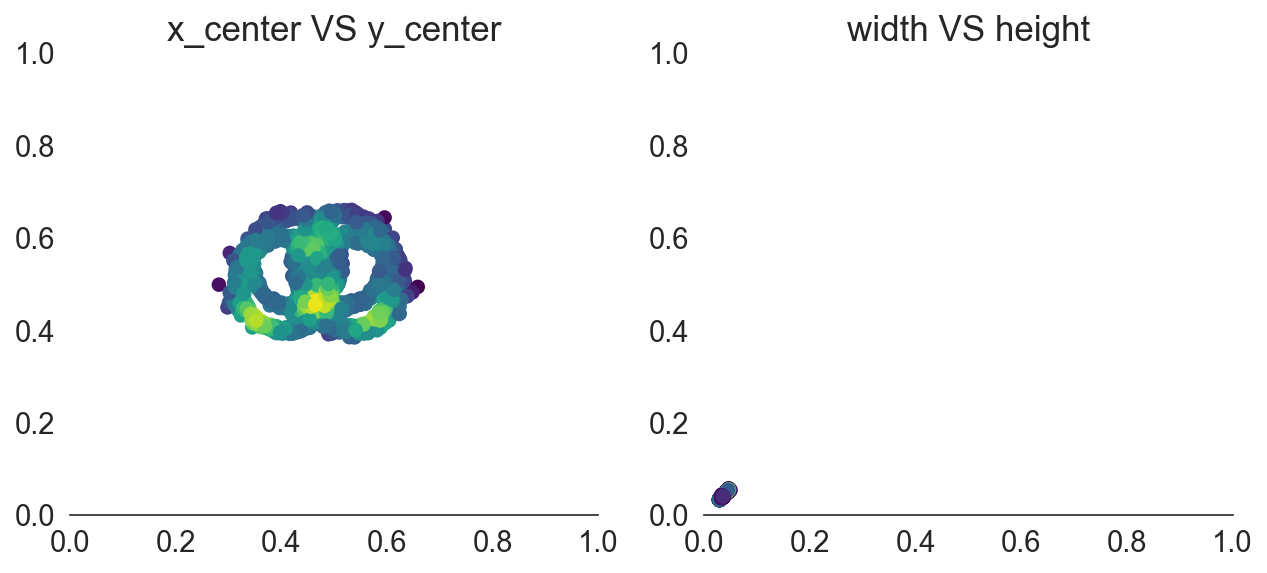

In [15]:
def plot_bbox_dist(df, bbox_format='yolo'):  
    """  
    Plot bbox distribution  
    df: Name of the Dataframe with following columns:  
    • image_path: Path to the image (If bbox format is 'voc' or 'coco') 
    • bboxes: Bboxes in YOLO [[xmid,ymid,w,h][xmid,ymid,w,h]] or VOC [[x,y,x,y][x,y,x,y]] format 
    """ 
    if bbox_format=='yolo':
        x_mids = [df["bboxes"][i][k][0] for i in range(len(df)) for k in range(len(df["bboxes"][i]))]
        y_mids = [df["bboxes"][i][k][1] for i in range(len(df)) for k in range(len(df["bboxes"][i]))]
        widths = [df["bboxes"][i][k][2] for i in range(len(df)) for k in range(len(df["bboxes"][i]))]
        heights =[df["bboxes"][i][k][3] for i in range(len(df)) for k in range(len(df["bboxes"][i]))]
    elif bbox_format=='pascal_voc':
        x_mids = [((df["bboxes"][i][k][2]+df["bboxes"][i][k][0])/2)/Image.open(df["image_path"][i]).size[0] for i in range(len(df)) for k in range(len(df["bboxes"][i]))]
        y_mids = [((df["bboxes"][i][k][3]+df["bboxes"][i][k][1])/2)/Image.open(df["image_path"][i]).size[1] for i in range(len(df)) for k in range(len(df["bboxes"][i]))]
        widths =  [(df["bboxes"][i][k][2]-df["bboxes"][i][k][0])/Image.open(df["image_path"][i]).size[0] for i in range(len(df)) for k in range(len(df["bboxes"][i]))]
        heights = [(df["bboxes"][i][k][3]-df["bboxes"][i][k][1])/Image.open(df["image_path"][i]).size[1] for i in range(len(df)) for k in range(len(df["bboxes"][i]))]
    elif bbox_format=='coco':
        x_mids = [((df["bboxes"][i][k][2]+df["bboxes"][i][k][0])/2)/Image.open(df["image_path"][i]).size[0] for i in range(len(df)) for k in range(len(df["bboxes"][i]))]
        y_mids = [((df["bboxes"][i][k][3]+df["bboxes"][i][k][1])/2)/Image.open(df["image_path"][i]).size[1] for i in range(len(df)) for k in range(len(df["bboxes"][i]))]
        widths = [df['bboxes'][i][k][2]/Image.open(df["image_path"][i]).size[0] for i in range(len(df)) for k in range(len(df['bboxes'][i]))]
        heights = [df['bboxes'][i][k][3]/Image.open(df["image_path"][i]).size[1] for i in range(len(df)) for k in range(len(df['bboxes'][i]))]
    elif bbox_format=='albumentations':
        x_mids = [((df["bboxes"][i][k][2]+df["bboxes"][i][k][0])/2) for i in range(len(df)) for k in range(len(df["bboxes"][i]))]
        y_mids = [((df["bboxes"][i][k][3]+df["bboxes"][i][k][1])/2) for i in range(len(df)) for k in range(len(df["bboxes"][i]))]
        widths =  [(df["bboxes"][i][k][2]-df["bboxes"][i][k][0]) for i in range(len(df)) for k in range(len(df["bboxes"][i]))]
        heights = [(df["bboxes"][i][k][3]-df["bboxes"][i][k][1]) for i in range(len(df)) for k in range(len(df["bboxes"][i]))]

    from scipy.stats import gaussian_kde  
    xy = np.vstack([x_mids,y_mids])  
    z = gaussian_kde(xy)(xy)  
    wh = np.vstack([widths,heights])  
    v = gaussian_kde(wh)(wh)  

    fig = plt.figure(figsize=(10, 4), dpi=150)   
    gs = fig.add_gridspec(1,2) # Create subplots & specify (#rows, #columns)   
    gs.update(wspace=0.2, hspace=0.2) # Specify spaces between subplot (#rows, #columns)   
    ax0 = fig.add_subplot(gs[0, 0]) # Place plot on a subplot [row_idx, column_idx]  
    ax1 = fig.add_subplot(gs[0, 1]) # Place plot on a subplot [row_idx, column_idx]  
    ax0.set(xlim=(0,1), ylim=([0,1])) # Set custom limits for graph  
    ax1.set(xlim=(0,1), ylim=([0,1])) # Set custom limits for graph  

    ax0.scatter(x_mids, y_mids, c=z, cmap='viridis')  
    ax0.set_title("x_center VS y_center")  
    ax1.scatter(widths, heights, c=v, cmap='viridis')  
    ax1.set_title("width VS height")  
    plt.show()
    
plot_bbox_dist(df, bbox_format='pascal_voc')

In [16]:
def get_bbox_outlier_indexes(x, y, num_huge=10, num_tiny=10, bbox_format="albumentations"): 
    """
    Finds outlier bboxes in dataframe or array
    x: Image array generated by cv2.imread("img.jpg")[..., ::-1] or image_path column of dataframe
    y: bbox array or bbox column of dataframe in this format → [[x,y,w,h], [x,y,w,h]]
    num_huge: Number of huge bbox outliers you want to see
    num_tiny: Number of tiny bbox outliers you want to see
    bbox_format: "albumentations", "voc" or "yolo" based on bbox format of your data 
    """
    huge_bbox_indexes,tiny_bbox_indexes = [],[]

    if isinstance(x, pd.Series) or isinstance(x, list):
        width = [Image.open(a).size[0] for a in x]
        height = [Image.open(a).size[1] for a in x]
    elif isinstance(x, np.ndarray):
        width = [a.shape[1] for a in x]
        height = [a.shape[0] for a in x]
    else:
        print("There's a problem with your data format")
        return

    asd = pd.DataFrame({'bboxes': y, 'width': width, 'height': height, 'max_areas':np.zeros(len(width)), 'min_areas':np.zeros(len(width))})
    asd['len_boxes'] = asd['bboxes'].apply(lambda x: len(x))
    asd = asd[asd['len_boxes']>0]
    if bbox_format=="albumentations":
        for i in asd.index:
            areas = []
            for k,bbox in enumerate (asd['bboxes'][i]):
                areas.append((bbox[2]-bbox[0])*(bbox[3]-bbox[1])*asd['width'][i]*asd['height'][i])
            asd['max_areas'][i] = max(areas)
            asd['min_areas'][i] = min(areas)
    elif bbox_format=="pascal_voc":
        for i in asd.index:
            areas = []
            for k,bbox in enumerate (asd['bboxes'][i]):
                areas.append((bbox[2]-bbox[0])*(bbox[3]-bbox[1]))
            asd['max_areas'][i] = max(areas)
            asd['min_areas'][i] = min(areas)
    elif bbox_format=="yolo":
        for i in asd.index:
            areas = []
            for k,bbox in enumerate (asd['bboxes'][i]):
                areas.append(bbox[2]*asd['width'][i]*bbox[3]*asd['height'][i])
            asd['max_areas'][i] = max(areas)
            asd['min_areas'][i] = min(areas)
    elif bbox_format=="coco":
        for i in asd.index:
            areas = []
            for k,bbox in enumerate (asd['bboxes'][i]):
                areas.append(bbox[2]*bbox[3])
            asd['max_areas'][i] = max(areas)
            asd['min_areas'][i] = min(areas)
    else:
        print("Please pick bbox format")
        return
    huge_bbox_indexes = asd.sort_values(by=['max_areas'], ascending=False).index[:num_huge]
    tiny_bbox_indexes = asd.sort_values(by=['min_areas']).index[:num_tiny]

    return huge_bbox_indexes, tiny_bbox_indexes

hugebox_indexes,tinybox_indexes = get_bbox_outlier_indexes(df["image_path"],df["bboxes"],num_huge=2, num_tiny=2, bbox_format="pascal_voc")

In [17]:
import random
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot
import seaborn as sns
import os
import cv2
from PIL import Image
import albumentations as A

class ImageAugmentation:
    def __init__(self):
        pass

    @classmethod
    def preprocess(cls, x, bboxes, classes, titles, bbox_format, im_size, num_samples):
        samples = random.sample(range(len(x)),num_samples) if num_samples !=0 else range(len(x)) # Take required number of samples
        
        x = x.values.tolist() if isinstance(x, pd.Series) else x
        bboxes = bboxes.values if isinstance(bboxes, pd.Series) else bboxes
        classes = classes.values if isinstance(classes, pd.Series) else classes
        titles = titles.values if isinstance(titles, pd.Series) else titles

        bboxes = [bboxes[i] for i in samples] if bboxes is not None and num_samples !=0 else bboxes
        classes = [classes[i] for i in samples] if classes is not None and num_samples !=0 else classes
        titles = [titles[i] for i in samples] if titles is not None and num_samples !=0 else classes

        if isinstance(x, list):
            x = np.array([np.array(Image.open(x[i]).convert('RGB')) for i in samples])
        elif isinstance(x, np.ndarray):
            x = np.array([x[i] for i in samples]) if num_samples != 0 else x
        else:
            print("There's a problem with your image data format")
            return
        
        if im_size is not None:
            if bboxes is not None and (bbox_format == 'pascal_voc' or bbox_format == 'coco'):
                bboxes = copy.deepcopy(bboxes)
                for i,bbox in enumerate(bboxes):
                    for k,box in enumerate(bbox):
                        box[0] = box[0]/x[i].shape[1]*im_size[0]
                        box[1] = box[1]/x[i].shape[0]*im_size[1]
                        box[2] = box[2]/x[i].shape[1]*im_size[0]
                        box[3] = box[3]/x[i].shape[0]*im_size[1]
            x = np.array([cv2.resize(img, im_size) for img in x], dtype="uint8")               
        return x, bboxes, classes, titles

    @classmethod
    def just_plot(cls, x, bboxes=None, classes=None, titles=None, bbox_format=None, num_samples=0, im_size=None, num_cols=4, plot_gap=5, mode="plot"):
        """Doesn't make any change, useful for creating array, plotting original images, resizing or copying
        x: Array containing images or series/list containing image paths
        bboxes: Array, series or list containing bbox coordinates [[0.12, 0.12, 0.12, 0.12], [0.35, 0.52, 0.62, 0.31]]
        classes: Array, series or list contraining labels for each bbox [[plate, plate], [plate]]
        bbox_format: Format of the bboxes. 'pascal_voc', 'albumentations', 'coco' or 'yolo'
        titles: Array, series or list containing title for each image while plotting (usually filename)
        """
        x,bboxes,classes, titles = cls.preprocess(x=x, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_samples=num_samples, im_size=im_size)
        return cls._plot_or_return(x=x, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_cols=num_cols, plot_gap=plot_gap, mode=mode)

    @classmethod
    def _plot_or_return(cls, x, bboxes=None, classes=None, bbox_format=None, titles=None, num_cols=4, plot_gap=5, mode="plot"):
        if bboxes is None:
            if mode == "plot":
                titles = [""] * len(x) if titles[0]=='' else titles
                plt.figure(figsize=(23,len(x)/num_cols*plot_gap))
                for i in range(len(x)):
                    plt.subplot(int(len(x)/num_cols)+1,num_cols,i+1)
                    plt.title(titles[i])
                    plt.imshow(x[i])
                plt.tight_layout()
                plt.show()
            elif mode == "return":
                return np.array(x, dtype="uint8")
        else:
            if classes is not None:
                bbox_labels = np.array([le.inverse_transform(i) for i in classes])
                bbox_labels = [el.tolist() if el.size > 0 else '' for el in bbox_labels]
            else:
                bbox_labels=None
            if mode=='plot':
                cls.plot_bboxes(x=x, y=bboxes, bbox_labels=bbox_labels, titles=titles, bbox_format=bbox_format, num_cols=num_cols, plot_gap=plot_gap)
            elif mode=='return':
                return np.array(x), bboxes, classes, titles
    
    @classmethod
    def save(cls, x, y=None, z=None, bbox_format=None, folder_name="dataset", sub_folder_name="images", im_size=None, num_samples=0):
        """
        Save images in given folder
        x: Array containing images or dataframe column containing image paths
        y: Array, list or DF column containing labels for each image (save images for each label folder)
        z: Array, list or DF column containing names for each image (including format)
        folder_name: Name of the folder to be created in current directory to save the images
        sub_folder_name: Name of the folder to be created in folder_name to save the images
        im_size= if specified as (width,height), resize image
        """
        x,bboxes,y,z = cls.preprocess(x=x, bboxes=None, classes=y, titles=z, bbox_format=bbox_format, num_samples=num_samples, im_size=im_size)

        if sub_folder_name==0:
            if not os.path.exists(folder_name):os.mkdir(folder_name)
        else:
            if not os.path.exists(folder_name): os.mkdir(folder_name)
            if not os.path.exists(os.path.join(folder_name,sub_folder_name)): os.mkdir(os.path.join(folder_name,sub_folder_name))
            folder_name = os.path.join(folder_name,sub_folder_name)

        for i in range(len(x)):
            if y is None and z is None: # both z and y missing
                try:
                    pyplot.imsave(os.path.join(folder_name,"image %d.png" %i), x[i])
                except:
                    print("%s could not be copied" % os.path.join(folder_name,"image %d.png" %i))
            elif z is None: # only y exist
                if not os.path.exists(os.path.join(folder_name,y[i])): os.mkdir(os.path.join(folder_name,y[i]))
                try:
                    pyplot.imsave(os.path.join(folder_name,y[i],"image %d.png" %i), x[i])
                except:
                    print("%s could not be copied" % os.path.join(folder_name, y[i],"image %d.png" %i))
            elif y is None: # only z exist
                try:
                    pyplot.imsave(os.path.join(folder_name,z[i]), x[i])
                except:
                    print("%s could not be copied" % os.path.join(folder_name,z[i]))
            else: # both z and y exist
                if not os.path.exists(os.path.join(folder_name,y[i])): os.mkdir(os.path.join(folder_name,y[i]))
                try:
                    pyplot.imsave(os.path.join(folder_name,y[i],z[i]), x[i])
                except:
                    print("%s could not be copied" % os.path.join(folder_name,y[i],z[i]))

    @classmethod
    def plot_augmentations_for_single_image(cls, x, bboxes=None, classes=None, titles=None, bbox_format=None, im_size=None, num_cols=4, plot_gap=5, mode="plot"):
        """ This function Plot augmentations for single image to pick best augmentations for dataset. 
        If bboxes and classes None, plain images will be plotted.
        x: Array containing images or Series/list containing image paths
        bboxes: Series, array or list containing bbox coordinates. [[0.48, 0.53, 0.35, 0.19],[0.48, 0.53, 0.35, 0.19]]
        classes: Series, array pr list containing class of each bbox. [0, 1]
        bbox_format: Format of the bboxes. 'pascal_voc', 'albumentations', 'coco' or 'yolo'.
        im_size= if specified as (width,height), resize image
        num_cols: Column size while plotting. Set it 2 or 3 to see more details
        plot_gap: To increase image size or if images nest together, increase plot_gap size
        """
        x,bboxes,classes, titles = cls.preprocess(x=x, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_samples=1, im_size=im_size)
        chosen_image = x[0].copy()
        albumentation_list = [
            A.Affine(always_apply=False, p=1), 
            A.AdvancedBlur(always_apply=False, p=1, blur_limit=(3, 13), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=90, beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1)), 
            A.Blur(always_apply=False, p=1.0, blur_limit=(5, 10)), 
            A.ChannelDropout(always_apply=False, p=1.0, channel_drop_range=(1, 2), fill_value=0), 
            A.ChannelShuffle(always_apply=False, p=1.0), 
            A.CLAHE(always_apply=False, p=1.0, clip_limit=(13, 21), tile_grid_size=(23, 10)), 
            A.ColorJitter(always_apply=False, p=1.0, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), 
            A.CropAndPad(p=1, percent=0.1), 
            A.Downscale(always_apply=False, p=1.0, scale_min=0.15, scale_max=0.45, interpolation=0), 
            A.Equalize(always_apply=False, p=1.0, mode='cv', by_channels=True), 
            A.FancyPCA(always_apply=False, p=1.0, alpha=0.1), 
            A.Flip(always_apply=False, p=1), # Flip either horizontally, vertically or both horizontally and vertically. 
            A.GaussNoise(always_apply=False, p=1.0, var_limit=(150.0, 350.0), per_channel=True, mean=0.0), 
            A.GaussianBlur(always_apply=False, p=1.0, blur_limit=(3, 7), sigma_limit=0), 
            A.GlassBlur(always_apply=False, p=1.0, sigma=0.7, max_delta=4, iterations=2), 
            A.HorizontalFlip(always_apply=False, p=1), 
            A.HueSaturationValue(always_apply=False, p=1.0, hue_shift_limit=(40, 50), sat_shift_limit=(20, 157), val_shift_limit=(-20, 50)), 
            A.ISONoise(always_apply=False, p=1.0, intensity=(0.1, 0.5), color_shift=(0.25, 0.85)), 
            A.MedianBlur(always_apply=False, p=1.0, blur_limit=7), 
            A.MotionBlur(always_apply=False, p=1.0, blur_limit=(25, 33)), 
            A.MultiplicativeNoise(always_apply=False, p=1.0, multiplier=(0.6, 1.7), per_channel=True, elementwise=True), 
            A.Perspective(always_apply=False, p=1.0, scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1), 
            A.PiecewiseAffine(always_apply=False, p=1), 
            A.PixelDropout(always_apply=False, p=1, dropout_prob=0.05, drop_value=0), 
            A.Posterize(always_apply=False, p=1.0, num_bits=[(0, 5), (0, 8), (0, 6)]), 
            A.RandomBrightness(always_apply=False, p=1.0, limit=(-0.4, 0.5)), 
            A.RandomBrightnessContrast(always_apply=False, p=1.0, brightness_limit=(-0.4, 0.5), contrast_limit=(-0.4, 0.5), brightness_by_max=True), 
            A.RandomContrast(always_apply=False, p=1.0, limit=(-0.9, 0.9)), 
            A.RandomCrop(always_apply=False, p=1, height=200, width=200), 
            A.RandomFog(always_apply=False, p=1.0, fog_coef_lower=0.22, fog_coef_upper=0.38, alpha_coef=1.0), 
            A.RandomGamma(always_apply=False, p=1.0, gamma_limit=(35, 150), eps=None), 
            A.RandomRain(always_apply=False, p=1.0, slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1, drop_color=(0, 0, 0), blur_value=4, brightness_coefficient=0.5, rain_type=None), 
            A.RandomResizedCrop(always_apply=False, p=1.0, height=150, width=150, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=0), 
            A.RandomRotate90(always_apply=False, p=1.0), 
            A.RandomShadow(always_apply=False, p=1.0, shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5), 
            A.RandomSnow(always_apply=False, p=1.0, snow_point_lower=0.1, snow_point_upper=0.8, brightness_coeff=2.5), 
            A.RandomSunFlare(always_apply=False, p=1), 
            A.RandomToneCurve(always_apply=False, p=1, scale=0.8), 
            A.Resize(always_apply=False, p=1, height=500, width=500), # You normally don't need, but keep it just in case 
            A.RGBShift(always_apply=False, p=1.0, r_shift_limit=(29, 20), g_shift_limit=(-20, 150), b_shift_limit=(-20, 150)), 
            A.RingingOvershoot(always_apply=False, p=1.0, blur_limit=(7, 15), cutoff=(0.7853981633974483, 1.5707963267948966)), 
            A.Rotate(always_apply=False, p=1.0, limit=(-90, 90), rotate_method='largest_box', crop_border=False), 
            A.SafeRotate(always_apply=False, p=1), 
            A.Sharpen(always_apply=False, p=1, alpha=(0.2, 0.5), lightness=(0.5, 1.0)),
            A.ShiftScaleRotate(always_apply=False, p=1.0, rotate_limit=(-90, 90),rotate_method='largest_box'),
            A.Solarize(always_apply=False, p=1.0, threshold=(150, 150)), 
            A.Superpixels(always_apply=False, p=1.0, p_replace=0.1, n_segments=100, max_size=128, interpolation=1), 
            A.Transpose(always_apply=False, p=1.0), 
            A.ToGray(always_apply=False, p=1.0), # Might come in handy later, don't use! 
            A.ToSepia(always_apply=False, p=1.0), 
            A.VerticalFlip(always_apply=False, p=1.0)]
        
        bbox_incompatible_albumentation_list = [
            A.CenterCrop(always_apply=False, p=1.0, height=150, width=150), 
            A.Crop(always_apply=False, p=1.0, x_min=0, y_min=0, x_max=200, y_max=200), 
            A.CoarseDropout(always_apply=False, p=1.0, max_holes=50, max_height=15, max_width=15, min_holes=None, min_height=None, min_width=None, fill_value=0), 
            A.ElasticTransform(always_apply=False, p=1.0, alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, value=None, mask_value=None),
            A.GridDistortion(always_apply=False, p=1.0, num_steps=5, distort_limit=0.8, interpolation=1, border_mode=4), 
            A.GridDropout(always_apply=False, p=1.0, ratio=0.5, unit_size_min=10, unit_size_max=10, holes_number_x=10, holes_number_y=10, shift_x=0, shift_y=0, random_offset=False, fill_value=0, mask_fill_value=None),
            A.OpticalDistortion(always_apply=False, p=1.0, distort_limit=0.4, shift_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None),
            A.RandomGridShuffle(always_apply=False, p=1.0, grid=(3, 3))]
      
        titles_list = ["Original","Affine", "AdvancedBlur", "Blur","ChannelDropout", 
               "ChannelShuffle", "CLAHE", "ColorJitter","CropAndPad",  
               "Downscale","Equalize", "FancyPCA", "Flip", "GaussNoise",  
               "GaussianBlur", "GlassBlur","HorizontalFlip",  
               "HueSaturationValue", "ISONoise", "MedianBlur","MotionBlur","MultiplicativeNoise",  
               "Perspective","PiecewiseAffine", "PixelDropout", "Posterize", 
               "RandomBrightness", "RandomBrightnessContrast", "RandomContrast","RandomCrop",  
               "RandomFog", "RandomGamma","RandomRain", "RandomResizedCrop",  
               "RandomRotate90", "RandomShadow", "RandomSnow", "RandomSunFlare", "RandomToneCurve", 
               "Resize", "RGBShift", "Rotate", "RingingOvershoot", "SafeRotate", "Sharpen", "ShiftScaleRotate",  
               "Solarize", "Superpixels","Transpose", "ToGray", "ToSepia", "VerticalFlip" ]
        
        bbox_incompatible_titles_list = ['CenterCrop', 'Crop', 'CoarseDropout', 'ElasticTransform',
                           'GridDistortion', 'GridDropout', 'OpticalDistortion', 'RandomGridShuffle']

        x_aug,bboxes_aug,classes_aug = [],[],[]
        
        if bboxes is None and classes is None:
            titles_list.extend(bbox_incompatible_titles_list)
            albumentation_list.extend(bbox_incompatible_albumentation_list)
            for aug_type in albumentation_list:
                transform = A.Compose([aug_type])
                transformed = transform(image = chosen_image)
                if np.isnan(transformed['image']).any() or transformed['image'].max() > 255 or transformed['image'].min() < 0:
                    x_aug.append(chosen_image)
                else:
                    x_aug.append(transformed['image'])
            x_aug.insert(0,chosen_image) #insert original image at the beginning
            if im_size is not None: x_aug = np.array([cv2.resize(x_aug[i], im_size) for i in range(len(x_aug))], dtype="uint8")
            return cls._plot_or_return(x=x_aug, titles=titles_list, num_cols=num_cols, plot_gap=plot_gap, mode=mode)
        elif bboxes is not None and classes is not None:
            chosen_bbox,chosen_id = bboxes[0].copy(),classes[0].copy()
            for aug_type in albumentation_list:
                transform = A.Compose([aug_type], bbox_params=A.BboxParams(format=bbox_format, label_fields=['category_ids'], min_visibility=0.3))
                transformed = transform(image = chosen_image, bboxes=chosen_bbox, category_ids=chosen_id)
                if np.isnan(transformed['image']).any() or transformed['image'].max() > 255 or transformed['image'].min() < 0:
                    x_aug.append(chosen_image) 
                else:
                    x_aug.append(transformed['image'])
                    bboxes_aug.append(list(transformed['bboxes']))
                    classes_aug.append(transformed['category_ids'])
            x_aug.insert(0,chosen_image)
            bboxes_aug.insert(0,chosen_bbox)
            classes_aug.insert(0,chosen_id)
            return cls._plot_or_return(x=x_aug, bboxes=bboxes_aug, classes=classes_aug, titles=titles_list, bbox_format=bbox_format, num_cols=num_cols, plot_gap=plot_gap, mode=mode)

    @classmethod
    def augment_images(cls, x, bboxes=None, classes=None, titles=None, bbox_format=None, im_size=None, num_samples=0, num_cols=2, plot_gap=6, mode="plot"):
        """
        Create new batch from dataset after applying augmentation
        x: Array containing images or dataframe column containing image paths
        im_size= if specified as (width,height), resize image
        num_samples: If x is too large, you may only crop & plot few random samples
        num_cols: Column size while plotting. Set it 2 or 3 to see more details
        plot_gap: To increase image size or if images nest together, increase plot_gap size
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs
        """
        x,bboxes,classes,titles = cls.preprocess(x=x, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_samples=num_samples, im_size=im_size)
        
        albumentation_list = [
            A.Affine(always_apply=False, p=0.5), 
            A.AdvancedBlur(always_apply=False, p=0.5, blur_limit=(3, 13), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=90, beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1)), 
            A.Blur(always_apply=False, p=0.5, blur_limit=(5, 10)), 
            A.ChannelDropout(always_apply=False, p=0.5, channel_drop_range=(1, 2), fill_value=0), 
            A.ChannelShuffle(always_apply=False, p=0.5), 
            A.CLAHE(always_apply=False, p=0.5, clip_limit=(13, 21), tile_grid_size=(23, 10)), 
            A.ColorJitter(always_apply=False, p=0.5, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), 
            #A.CropAndPad(p=0.5, percent=0.1), 
            A.Downscale(always_apply=False, p=0.5, scale_min=0.15, scale_max=0.45, interpolation=0), 
            A.Equalize(always_apply=False, p=0.5, mode='cv', by_channels=True), 
            A.FancyPCA(always_apply=False, p=0.5, alpha=0.1), 
            A.Flip(always_apply=False, p=0.5), # Flip either horizontally, vertically or both horizontally and vertically. 
            A.GaussNoise(always_apply=False, p=0.5, var_limit=(150.0, 350.0), per_channel=True, mean=0.0), 
            A.GaussianBlur(always_apply=False, p=0.5, blur_limit=(3, 7), sigma_limit=0), 
            A.GlassBlur(always_apply=False, p=0.5, sigma=0.7, max_delta=4, iterations=2), 
            A.HorizontalFlip(always_apply=False, p=0.5), 
            A.HueSaturationValue(always_apply=False, p=0.5, hue_shift_limit=(40, 50), sat_shift_limit=(20, 157), val_shift_limit=(-20, 50)), 
            A.ISONoise(always_apply=False, p=0.5, intensity=(0.1, 0.5), color_shift=(0.25, 0.85)), 
            A.MedianBlur(always_apply=False, p=0.5, blur_limit=7), 
            A.MotionBlur(always_apply=False, p=0.5, blur_limit=(25, 33)), 
            A.MultiplicativeNoise(always_apply=False, p=0.5, multiplier=(0.6, 1.7), per_channel=True, elementwise=True), 
            A.Perspective(always_apply=False, p=0.5, scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1), 
            A.PiecewiseAffine(always_apply=False, p=0.5), 
            A.PixelDropout(always_apply=False, p=0.5, dropout_prob=0.05, drop_value=0), 
            A.Posterize(always_apply=False, p=0.5, num_bits=[(0, 5), (0, 8), (0, 6)]), 
            A.RandomBrightness(always_apply=False, p=0.5, limit=(-0.4, 0.5)), 
            A.RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.4, 0.5), contrast_limit=(-0.4, 0.5), brightness_by_max=True), 
            A.RandomContrast(always_apply=False, p=0.5, limit=(-0.9, 0.9)), 
            #A.RandomCrop(always_apply=False, p=0.5, height=200, width=200), 
            A.RandomFog(always_apply=False, p=0.5, fog_coef_lower=0.22, fog_coef_upper=0.38, alpha_coef=1.0), 
            A.RandomGamma(always_apply=False, p=0.5, gamma_limit=(35, 150), eps=None), 
            A.RandomRain(always_apply=False, p=0.5, slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1, drop_color=(0, 0, 0), blur_value=4, brightness_coefficient=0.5, rain_type=None), 
            A.RandomResizedCrop(always_apply=False, p=0.5, height=150, width=150, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=0), 
            A.RandomRotate90(always_apply=False, p=0.5), 
            A.RandomShadow(always_apply=False, p=0.5, shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5), 
            A.RandomSnow(always_apply=False, p=0.5, snow_point_lower=0.1, snow_point_upper=0.8, brightness_coeff=2.5), 
            A.RandomSunFlare(always_apply=False, p=0.5), 
            A.RandomToneCurve(always_apply=False, p=0.5, scale=0.8), 
            #A.Resize(always_apply=False, p=0.5, height=500, width=500), # You normally don't need, but keep it just in case 
            A.RGBShift(always_apply=False, p=0.5, r_shift_limit=(29, 20), g_shift_limit=(-20, 150), b_shift_limit=(-20, 150)), 
            A.RingingOvershoot(always_apply=False, p=0.5, blur_limit=(7, 15), cutoff=(0.7853981633974483, 1.5707963267948966)), 
            A.Rotate(always_apply=False, p=0.5, limit=(-90, 90), rotate_method='largest_box', crop_border=False), 
            A.SafeRotate(always_apply=False, p=0.5), 
            A.Sharpen(always_apply=False, p=0.5, alpha=(0.2, 0.5), lightness=(0.5, 1.0)), 
            A.ShiftScaleRotate(always_apply=False, p=0.5, rotate_limit=(-90, 90),rotate_method='largest_box'), 
            A.Solarize(always_apply=False, p=0.5, threshold=(150, 150)), 
            A.Superpixels(always_apply=False, p=0.5, p_replace=0.1, n_segments=100, max_size=128, interpolation=1), 
            A.Transpose(always_apply=False, p=0.5), 
            A.ToGray(always_apply=False, p=0.5), # Might come in handy later, don't use! 
            A.ToSepia(always_apply=False, p=0.5), 
            A.VerticalFlip(always_apply=False, p=0.5)]
        
        bbox_incompatible_albumentation_list = [
            A.CenterCrop(always_apply=False, p=0.5, height=150, width=150),
            A.Crop(always_apply=False, p=0.5, x_min=0, y_min=0, x_max=200, y_max=200),
            A.CoarseDropout(always_apply=False, p=0.5, max_holes=50, max_height=15, max_width=15, min_holes=None, min_height=None, min_width=None, fill_value=0), 
            A.ElasticTransform(always_apply=False, p=0.5, alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, value=None, mask_value=None),
            A.GridDistortion(always_apply=False, p=0.5, num_steps=5, distort_limit=0.8, interpolation=1, border_mode=4), 
            A.GridDropout(always_apply=False, p=0.5, ratio=0.5, unit_size_min=10, unit_size_max=10, holes_number_x=10, holes_number_y=10, shift_x=0, shift_y=0, random_offset=False, fill_value=0, mask_fill_value=None),
            A.OpticalDistortion(always_apply=False, p=0.5, distort_limit=0.4, shift_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None),
            A.RandomGridShuffle(always_apply=False, p=0.5, grid=(3, 3))]
        
        x_aug,bboxes_aug,classes_aug = [],[],[]
        
        if bboxes is None and classes is None:
            albumentation_list.extend(bbox_incompatible_albumentation_list)
            for i in range(len(x)):
                transform = A.Compose([A.SomeOf(albumentation_list, 3, replace=True, p=1)])
                transformed = transform(image = x[i].copy())
                if np.isnan(transformed['image']).any() or transformed['image'].max() > 255 or transformed['image'].min() < 0:
                    x_aug.append(x[i])
                else:
                    x_aug.append(transformed['image'])
                    
            if im_size[0]!="": x_aug = np.array([cv2.resize(x_aug[i], im_size) for i in range(len(x_aug))], dtype="uint8")
                
            return cls._plot_or_return(x=x_aug, num_cols=num_cols, plot_gap=plot_gap, mode=mode)
        elif bboxes is not None and classes is not None:
            if len(bboxes) != len(classes) or len(classes) != len(x): return print('You should have same #images, #bboxes and #classes')
            for i in range(len(x)):
                transform = A.Compose([A.SomeOf(albumentation_list, 3, replace=True, p=1)], bbox_params=A.BboxParams(format=bbox_format, label_fields=['category_ids'], min_visibility=0.3))
                transformed = transform(image = x[i].copy(),bboxes=bboxes[i].copy(),category_ids=classes[i].copy())
                if np.isnan(transformed['image']).any() or transformed['image'].max() > 255 or transformed['image'].min() < 0:
                    x_aug.append(x[i])
                    bboxes_aug.append([''])
                    classes_aug.append([''])
                else:
                    x_aug.append(transformed['image'])
                    bboxes_aug.append(list(transformed['bboxes']))
                    classes_aug.append(transformed['category_ids'])
            return cls._plot_or_return(x=x_aug, bboxes=bboxes_aug, classes=classes_aug, titles=titles, bbox_format=bbox_format, num_cols=num_cols, plot_gap=plot_gap, mode=mode)

    @classmethod
    def plot_bboxes(cls, x, y, bbox_labels=None, titles=None, bbox_format="albumentations", num_cols=3, plot_gap=2): 
        """ 
        Plot images with bboxes from array or dataframe 
        x: Image array generated by cv2.imread("img.jpg")[..., ::-1] or image_path column of dataframe 
        y: Array or dataframe column containing bbox coordinates  
        bbox_labels: array or dataframe column containing labels for each bboxes 
        indexes: indexes of the images as a list you want to plot (e.g tinybox_indexes or [1, 64, 53]) 
        titles: array or dataframe column containing title for each image while plotting(usually filename)
        bbox_format: "albumentations", "pascal_voc", "coco" or "yolo" based on bbox format of your data  
        """ 
        # Turn filenames into desired list format 
        titles = [""] * len(x) if titles is None else titles
        
        width,height = [a.shape[1] for a in x], [a.shape[0] for a in x]
        
        plt.figure(figsize=(20,len(x)/num_cols*plot_gap)) # Increase plot_gap if images nested together
        for i,bboxes in enumerate(y): 
            img = x[i] if x[i].max() <= 1 else x[i]/255 
            if len(bboxes) == 0:
                plt.subplot(int(len(x)/num_cols)+1,num_cols,i+1) 
                plt.title(str(titles[i]) + "\n" + str(img.shape)) 
                plt.imshow(img) 
                continue 
            else:
                for k, bbox in enumerate(bboxes): 
                    if bbox_format=="albumentations": 
                        [x1,y1,x2,y2] = [bbox[0]*width[i], bbox[1]*height[i], bbox[2]*width[i], bbox[3]*height[i]] 
                        [x1,y1,x2,y2] = [int(x) for x in [x1,y1,x2,y2]] 
                    elif bbox_format=="pascal_voc": 
                        [x1,y1,x2,y2] = bbox 
                        [x1,y1,x2,y2] = [int(x) for x in [x1,y1,x2,y2]] 
                    if bbox_format=="yolo": 
                        xcenter, ycenter, w, h = bbox
                        x1 = int((xcenter - w / 2) * width[i])
                        x2 = int((xcenter + w / 2) * width[i])
                        y1 = int((ycenter - h / 2) * height[i])
                        y2 = int((ycenter + h / 2) * height[i])
                        if x1 < 0: x1 = 0
                        if x2 > width[i] - 1: x2 = width[i] - 1
                        if y1 < 0: y1 = 0
                        if y2 > height[i] - 1: y1 = height[i] - 1
                    if bbox_format=="coco":
                        x1, y1, w, h = bbox
                        x2, y2 = x1 + w, y1 + h
                        [x1,y1,x2,y2] = [int(x) for x in [x1,y1,x2,y2]]
                    plt.subplot(int(len(x)/num_cols)+1,num_cols,i+1)
                    cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)
                    if bbox_labels is not None: cv2.putText(img, bbox_labels[i][k], (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), 4)
                    plt.title(str(titles[i]) + "\n" + str(img.shape))
                plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


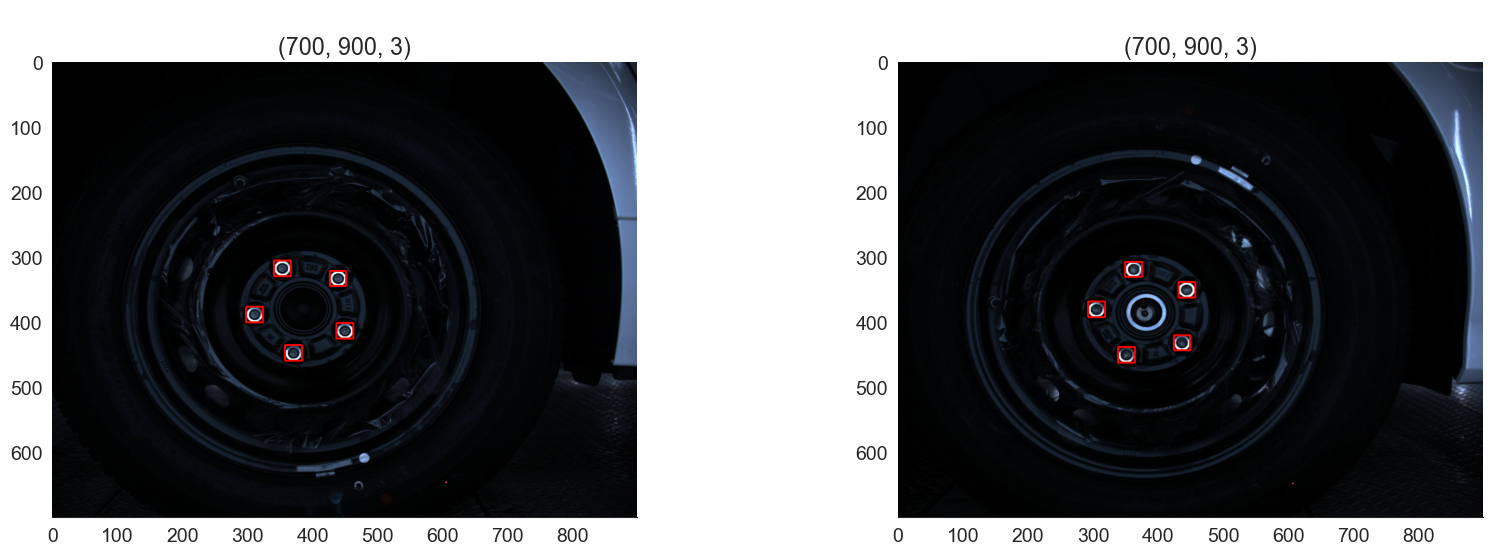

In [18]:
ImageAugmentation.just_plot(x=[df["image_path"][i] for i in tinybox_indexes], bboxes=[df["bboxes"][i] for i in tinybox_indexes], titles=[df["file_name"][i] for i in tinybox_indexes], bbox_format="pascal_voc",num_cols=2, plot_gap=13, im_size=(900,700))

# **11. Image Processing**

In [19]:
import imutils
import albumentations as A
class ImageProcess:
    def __init__(self):
        pass

    @classmethod
    def preprocess(cls, x, bboxes, classes, titles, bbox_format, im_size, num_samples):
        samples = random.sample(range(len(x)),num_samples) if num_samples !=0 else range(len(x)) # Take required number of samples
        
        x = x.values.tolist() if isinstance(x, pd.Series) else x
        bboxes = bboxes.values if isinstance(bboxes, pd.Series) else bboxes
        classes = classes.values if isinstance(classes, pd.Series) else classes
        titles = titles.values if isinstance(titles, pd.Series) else titles

        bboxes = [bboxes[i] for i in samples] if bboxes is not None and num_samples !=0 else bboxes
        classes = [classes[i] for i in samples] if classes is not None and num_samples !=0 else classes
        titles = [titles[i] for i in samples] if titles is not None and num_samples !=0 else titles

        if isinstance(x, list):
            x = np.array([np.array(Image.open(x[i]).convert('RGB')) for i in samples])
        elif isinstance(x, np.ndarray):
            x = np.array([x[i] for i in samples]) if num_samples != 0 else x
        else:
            print("There's a problem with your image data format")
            return
        
        if im_size is not None:
            if bboxes is not None and (bbox_format == 'pascal_voc' or bbox_format == 'coco'):
                bboxes = copy.deepcopy(bboxes)
                for i,bbox in enumerate(bboxes):
                    for k,box in enumerate(bbox):
                        box[0] = box[0]/x[i].shape[1]*im_size[0]
                        box[1] = box[1]/x[i].shape[0]*im_size[1]
                        box[2] = box[2]/x[i].shape[1]*im_size[0]
                        box[3] = box[3]/x[i].shape[0]*im_size[1]
            x = np.array([cv2.resize(img, im_size) for img in x], dtype="uint8")               
        return x, bboxes, classes, titles

    @classmethod
    def plotOrReturn(cls, x, mode, num_samples, num_cols, plot_gap):
        if mode == "plot":
            plt.figure(figsize=(23,num_samples*plot_gap))
            for i in random.sample(range(len(x)), num_samples):
                plt.subplot(int(num_samples/num_cols)+1,num_cols,i+1)
                plt.imshow(x[i-1])
            plt.show()
        elif mode == "return":
            return np.array(x, dtype="uint8")

    @classmethod
    def just_plot(cls, x, bboxes=None, classes=None, titles=None, bbox_format=None, num_samples=0, im_size=None, num_cols=4, plot_gap=5, mode="plot"):
        """Doesn't make any change, useful for creating array, plotting original images, resizing or copying
        x: Array containing images or series/list containing image paths
        bboxes: Array, series or list containing bbox coordinates [[0.12, 0.12, 0.12, 0.12], [0.35, 0.52, 0.62, 0.31]]
        classes: Array, series or list contraining labels for each bbox [[plate, plate], [plate]]
        bbox_format: Format of the bboxes. 'pascal_voc', 'albumentations', 'coco' or 'yolo'
        titles: Array, series or list containing title for each image while plotting (usually filename)
        """
        x,bboxes,classes,titles = cls.preprocess(x=x, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_samples=num_samples, im_size=im_size)
        return cls._plot_or_return(x=x, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_cols=num_cols, plot_gap=plot_gap, mode=mode)

    @classmethod
    def _plot_or_return(cls, x, bboxes=None, classes=None, bbox_format=None, titles=None, num_cols=4, plot_gap=5, mode="plot"):
        if bboxes is None:
            if mode == "plot":
                titles = [""] * len(x) if titles is None else titles
                plt.figure(figsize=(23,len(x)/num_cols*plot_gap))
                for i in range(len(x)):
                    plt.subplot(int(len(x)/num_cols)+1,num_cols,i+1)
                    plt.title(titles[i])
                    plt.imshow(x[i])
                plt.tight_layout()
                plt.show()
            elif mode == "return":
                return np.array(x, dtype="uint8")
        else:
            if classes is not None:
                bbox_labels = np.array([le.inverse_transform(i) for i in classes])
                bbox_labels = [el.tolist() if el.size > 0 else '' for el in bbox_labels]
            else:
                bbox_labels=None
            if mode=='plot':
                cls.plot_bboxes(x=x, y=bboxes, bbox_labels=bbox_labels, titles=titles, bbox_format=bbox_format, num_cols=num_cols, plot_gap=plot_gap)
            elif mode=='return':
                return np.array(x), bboxes, classes, titles

    @classmethod
    def save(cls, x, y=None, z=None, bbox_format=None, folder_name="dataset", sub_folder_name="images", im_size=None, num_samples=0):
        """
        Save images in given folder
        x: Array containing images or dataframe column containing image paths
        y: Array, list or DF column containing labels for each image (save images for each label folder)
        z: Array, list or DF column containing names for each image (including format)
        folder_name: Name of the folder to be created in current directory to save the images
        sub_folder_name: Name of the folder to be created in folder_name to save the images
        im_size= if specified as (width,height), resize image
        """
        x,bboxes,y,z = cls.preprocess(x=x, bboxes=None, classes=y, titles=z, bbox_format=bbox_format, num_samples=num_samples, im_size=im_size)

        if sub_folder_name==0:
            if not os.path.exists(folder_name):os.mkdir(folder_name)
        else:
            if not os.path.exists(folder_name): os.mkdir(folder_name)
            if not os.path.exists(os.path.join(folder_name,sub_folder_name)): os.mkdir(os.path.join(folder_name,sub_folder_name))
            folder_name = os.path.join(folder_name,sub_folder_name)

        for i in range(len(x)):
            if y is None and z is None: # both z and y missing
                try:
                    pyplot.imsave(os.path.join(folder_name,"image %d.png" %i), x[i])
                except:
                    print("%s could not be copied" % os.path.join(folder_name,"image %d.png" %i))
            elif z is None: # only y exist
                if not os.path.exists(os.path.join(folder_name,y[i])): os.mkdir(os.path.join(folder_name,y[i]))
                try:
                    pyplot.imsave(os.path.join(folder_name,y[i],"image %d.png" %i), x[i])
                except:
                    print("%s could not be copied" % os.path.join(folder_name, y[i],"image %d.png" %i))
            elif y is None: # only z exist
                try:
                    pyplot.imsave(os.path.join(folder_name,z[i]), x[i])
                except:
                    print("%s could not be copied" % os.path.join(folder_name,z[i]))
            else: # both z and y exist
                if not os.path.exists(os.path.join(folder_name,y[i])): os.mkdir(os.path.join(folder_name,y[i]))
                try:
                    pyplot.imsave(os.path.join(folder_name,y[i],z[i]), x[i])
                except:
                    print("%s could not be copied" % os.path.join(folder_name,y[i],z[i]))

    @classmethod    
    def grayscale(cls, x, bboxes=None, classes=None, titles=None, bbox_format=None, im_size=None, num_samples=0, num_cols=2, plot_gap=6, mode="plot"):
        """
        Apply grayscale to images
        x: Array containing images or dataframe column containing image paths
        im_size= if specified as (width,height), resize image
        num_samples: If x is too large, you may only crop & plot few random samples
        num_cols: Column size while plotting. Set it 2 or 3 to see more details
        plot_gap: To increase image size or if images nest together, increase plot_gap size
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs
        """
        x,bboxes,classes,titles = cls.preprocess(x=x, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_samples=num_samples, im_size=im_size)
        set_new = []
        for img in x:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            set_new.append(img)
        return cls._plot_or_return(x=set_new, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_cols=num_cols, plot_gap=plot_gap, mode=mode)

    @classmethod    
    def add_weighted_blur(cls, x, alpha=4, sigmaX=10, beta=-4, constant=128, bboxes=None, classes=None, titles=None, bbox_format=None, im_size=None, num_samples=0, num_cols=2, plot_gap=6, mode="plot"):
        """
        Blend two images into one (original + blurred version)
        x: Array containing images or dataframe column containing image paths
        alpha: Try different parameters to find best results
        sigmaX: Try different parameters to find best results
        beta: Try different parameters to find best results
        constant: Try different parameters to find best results
        im_size= if specified as (width,height), resize image
        num_samples: If x is too large, you may only crop & plot few random samples
        num_cols: Column size while plotting. Set it 2 or 3 to see more details
        plot_gap: To increase image size or if images nest together, increase plot_gap size
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs
        """
        x,bboxes,classes,titles = cls.preprocess(x=x, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_samples=num_samples, im_size=im_size)

        set_new = []
        for img in x:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.addWeighted(img, alpha, cv2.GaussianBlur(img, (0,0), sigmaX), beta, constant)
            set_new.append(img)
        return cls._plot_or_return(x=set_new, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_cols=num_cols, plot_gap=plot_gap, mode=mode)

    @classmethod    
    def crop_from_gray(cls, x, tol=7, bboxes=None, classes=None, titles=None, bbox_format=None, im_size=(500,500), num_samples=0, num_cols=2, plot_gap=6, mode="plot"):
        """
        Crop image from gray areas after applying grayscale
        x: Array containing images or dataframe column containing image paths
        im_size(required)= After cropping, resize image as (width,height)
        num_samples: If x is too large, you may only crop & plot few random samples
        num_cols: Column size while plotting. Set it 2 or 3 to see more details
        tol: Tolerance. You may try different tolerances to find best parameter
        plot_gap: To increase image size or if images nest together, increase plot_gap size
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs
        """
        x,bboxes,classes,titles = cls.preprocess(x=x, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_samples=num_samples, im_size=im_size)
        set_new = []
        for img in x:
            if img.ndim ==2:
                img = cv2.resize(img, im_size)
                set_new.append(img)
            elif img.ndim==3:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                mask = gray > tol
                check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
                if (check_shape == 0):
                    img = cv2.resize(img, im_size)
                    set_new.append(img)
                else:
                    img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
                    img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
                    img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
                    img = np.stack([img1,img2,img3],axis=-1)
                img = cv2.resize(img, im_size)
                set_new.append(img)
        return cls._plot_or_return(x=set_new, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_cols=num_cols, plot_gap=plot_gap, mode=mode)

    @classmethod    
    def circle_crop(cls, x, bboxes=None, classes=None, titles=None, bbox_format=None, im_size=(500,500), num_samples=0, num_cols=2, plot_gap=6, mode="plot"):
        """
        Crop image to circle
        x: Array containing images or dataframe column containing image paths
        num_samples: If x is too large, you may only crop & plot few random samples
        im_size(required)= After cropping, resize image as (width,height)
        num_cols: Column size while plotting. Set it 2 or 3 to see more details
        plot_gap: To increase image size or if images nest together, increase plot_gap size
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs
        """
        x,bboxes,classes,titles = cls.preprocess(x=x, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_samples=num_samples, im_size=im_size)
        set_new = []
        for img in x:
            height, width, depth = img.shape
            x = int(width/2)
            y = int(height/2)
            r = np.amin((x,y))
            circle_img = np.zeros((height, width), np.uint8)
            cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
            img = cv2.bitwise_and(img, img, mask=circle_img)
            img = cv2.resize(img, im_size)
            set_new.append(img)
        return cls._plot_or_return(x=set_new, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_cols=num_cols, plot_gap=plot_gap, mode=mode)

    @classmethod
    def contour_utils(cls, x, draw_mode="square_crop", ccr=300, blur_size=(25,25), tresh_size=15, bboxes=None, classes=None, titles=None, bbox_format=None, im_size=(500,500), num_samples=0, num_cols=2, plot_gap=6, mode="plot"):  
        """  
        Getting different version of the images after applying contour based on draw mode
        x: Array containing images or dataframe column containing image paths
        draw_mode="bg_contour" -> Draw red contour lines on the background image (white or black background)
        draw_mode="bg_contour_cropped" -> Draw red contour lines on the background image & crop from extreme points
        draw_mode="contour_filled" -> Fill contour are with specific color (black or white)
        draw_mode="contour_filled_reversed" -> Fill outside the contour are with specific color (black or white)
        draw_mode="contour_crop" -> Crop image from contour lines & fill the rest with color
        draw_mode="square_crop" -> Crop the image from contour extreme points
        draw_mode="contour_center_crop" -> Crop the image from the center of contours
        draw_mode="contour_center_crop_fill" -> Crop the image from the center of contours & fill the rest with black
        ccr: Center Crop Radius. It's used when cropping center of the contour
        blur_size: try different parameters to pick best blur size that crops perfectly 
        num_samples: If x is too large, you may only crop & plot few random samples 
        im_size(required)= After cropping, resize image as (width,height)
        num_cols: Column size while plotting. Set it 2 or 3 to see more details 
        tresh_size: try different parameters to pick best tresh size that crops perfectly 
        plot_gap: To increase image size or if images nest together, increase plot_gap size
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs 
        """           
        x,bboxes,classes,titles = cls.preprocess(x=x, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_samples=num_samples, im_size=im_size)

        set_new = []

        for img in x:
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
            gray = cv2.GaussianBlur(gray, blur_size, 0) 

            # threshold the image, then perform a series of erosions +  
            # dilations to remove any small regions of noise  
            thresh = cv2.threshold(gray, tresh_size, 255, cv2.THRESH_BINARY)[1] 
            thresh = cv2.erode(thresh, None, iterations=2)  
            thresh = cv2.dilate(thresh, None, iterations=2)  
            thresh = thresh.astype(np.uint8)

            # find contours in thresholded image, then grab the largest one  
            cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  
            cnts = imutils.grab_contours(cnts)  
            c = max(cnts, key=cv2.contourArea)

            # find the extreme points  
            extLeft = tuple(c[c[:, :, 0].argmin()][0])  
            extRight = tuple(c[c[:, :, 0].argmax()][0])  
            extTop = tuple(c[c[:, :, 1].argmin()][0])  
            extBot = tuple(c[c[:, :, 1].argmax()][0]) 

            # Create new image by drawing green contour on the image
            img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

            # Add colorful circles to extreme points
            img_pnt = cv2.circle(img_cnt.copy(), extLeft, int(im_size[0]/30), (0, 0, 255), -1) 
            img_pnt = cv2.circle(img_pnt, extRight, int(im_size[0]/30), (0, 255, 0), -1) 
            img_pnt = cv2.circle(img_pnt, extTop, int(im_size[0]/30), (255, 0, 0), -1) 
            img_pnt = cv2.circle(img_pnt, extBot, int(im_size[0]/30), (255, 255, 0), -1) 

            if mode == "asd":
                set_new.append(img_pnt)
            elif mode == "return" and draw_mode == "bg_contour":
                # or np.zeros(image.shape, np.uint8) for black background
                bg = np.ones(img.shape, np.uint8) * 255 
                bg_cnt = cv2.drawContours(bg.copy(), [c], -1, (255, 0, 0), 4)
                set_new.append(bg_cnt)
            elif mode == "return" and draw_mode == "bg_contour_cropped":
                # or np.zeros(image.shape, np.uint8) for black background
                bg = np.ones(img.shape, np.uint8) * 255 
                bg_cnt = cv2.drawContours(bg.copy(), [c], -1, (255, 0, 0), 4)
                bg_cnt_cropped = bg_cnt[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()
                bg_cnt_cropped = cv2.resize(bg_cnt_cropped, im_size)
                set_new.append(bg_cnt_cropped)
            elif mode == "return" and draw_mode == "contour_filled":
                # (0, 0, 0) -> (255, 255, 255) for white fill
                cnt_filled = cv2.drawContours(img.copy(), [c], -1, (0, 0, 0), -1)
                set_new.append(cnt_filled)
            elif mode == "return" and draw_mode == "contour_filled_reversed":
                mask = np.zeros_like(img)
                cv2.drawContours(mask, [c], 0, (255,255,255), -1)

                # apply mask to input image
                new_image = cv2.bitwise_and(img.copy(), mask)

                set_new.append(new_image)
            elif mode == "return" and draw_mode == "contour_crop":
                x,y,w,h = cv2.boundingRect(c)

                # draw filled contour on black background
                mask = np.zeros_like(img)
                cv2.drawContours(mask, [c], 0, (255,255,255), -1)

                # apply mask to input image
                new_image = cv2.bitwise_and(img.copy(), mask)

                # crop & resize
                ROI = new_image[y:y+h, x:x+w]
                ROI = cv2.resize(ROI, im_size)
                set_new.append(ROI)
            elif mode == "return" and draw_mode == "square_crop":
                # crop & resize the image
                new_img = img[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()  
                new_img = cv2.resize(new_img, im_size)
                set_new.append(new_img)
            elif mode == "return" and draw_mode == "contour_center_crop":
                mid_x = int((extRight[0]-extLeft[0])/2)+extLeft[0]
                mid_y = int((extTop[1]-extBot[1])/2)+extBot[1]
                ROI = img[mid_y-ccr:mid_y+ccr, mid_x-ccr:mid_x+ccr].copy()
                set_new.append(ROI)
            elif mode == "return" and draw_mode == "contour_center_crop_fill":
                mask = np.zeros(img.shape, dtype=np.uint8)
                mid_x = int((extRight[0]-extLeft[0])/2)+extLeft[0]
                mid_y = int((extTop[1]-extBot[1])/2)+extBot[1]
                cv2.circle(mask, (mid_x,mid_y), ccr, (255,255,255), -1)
                ROI = cv2.bitwise_and(img.copy(), mask)
                set_new.append(ROI)

        return cls._plot_or_return(x=set_new, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_cols=num_cols, plot_gap=plot_gap, mode=mode)

    @classmethod
    def hsv(cls, x, hue=0, sat=150, brt=0, bboxes=None, classes=None, titles=None, bbox_format=None, im_size=None, num_samples=0, num_cols=2, plot_gap=6, mode="plot"):
        """  
        Apply hsv to image. hue_shift changes color, sat_shift changes extremes.
        x: Array containing images or dataframe column containing image paths
        hue: try different parameters to pick best color 
        sat: try different parameters to pick best extremes 
        brt: brightness parameter
        num_samples: If x is too large, you may only crop & plot few random samples 
        num_cols: Column size while plotting. Set it 2 or 3 to see more details 
        im_size= if specified as (width,height), resize image
        plot_gap: To increase image size or if images nest together, increase plot_gap size
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs 
        """
        x,bboxes,classes,titles = cls.preprocess(x=x, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_samples=num_samples, im_size=im_size)
        
        transform = A.Compose([
            A.HueSaturationValue(p=1.0, hue_shift_limit=(hue, hue), sat_shift_limit=(sat, sat), val_shift_limit=(brt, brt))
        ])

        x_aug = [] 
        for i in range(len(x)):
            image = x[i].copy()
            transformed = transform(image=image)
            if np.isnan(transformed['image']).any() or transformed['image'].max() > 255: 
                continue
            else:
                x_aug.append(transformed['image'])

        x_aug = np.array(x_aug)

        return cls._plot_or_return(x=x_aug, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_cols=num_cols, plot_gap=plot_gap, mode=mode)

    @classmethod
    def solarize(cls, x, tresh=150, bboxes=None, classes=None, titles=None, bbox_format=None, im_size=None, num_samples=0, num_cols=2, plot_gap=6, mode="plot"):
        """  
        Apply solarize to image.
        Last parameter is brightness so no need to change.
        x: Array containing images or dataframe column containing image paths
        tresh: try different parameters to pick best extremes
        num_samples: If x is too large, you may only crop & plot few random samples 
        num_cols: Column size while plotting. Set it 2 or 3 to see more details 
        im_size= if specified as (width,height), resize image
        plot_gap: To increase image size or if images nest together, increase plot_gap size
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs 
        """
        x,bboxes,classes, titles = cls.preprocess(x=x, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_samples=num_samples, im_size=im_size)

        transform = A.Compose([A.Solarize(p=1.0, threshold=(tresh, tresh))])

        x_aug = [] 
        for i in range(len(x)):
            image = x[i].copy()
            transformed = transform(image=image)
            if np.isnan(transformed['image']).any() or transformed['image'].max() > 255: 
                continue
            else:
                x_aug.append(transformed['image'])

        x_aug = np.array(x_aug)

        return cls._plot_or_return(x=x_aug, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_cols=num_cols, plot_gap=plot_gap, mode=mode)

    @classmethod
    def clahe(cls, x, clip=15, tile=23, bboxes=None, classes=None, titles=None, bbox_format=None, im_size=None, num_samples=0, num_cols=2, plot_gap=6, mode="plot"):
        """  
        Apply solarize to image.
        Last parameter is brightness so no need to change.
        x: Array containing images or dataframe column containing image paths
        clip: try different parameters to pick best parameter
        tile: try different parameters to pick best parameter
        num_samples: If x is too large, you may only crop & plot few random samples 
        num_cols: Column size while plotting. Set it 2 or 3 to see more details 
        im_size= if specified as (width,height), resize image
        plot_gap: To increase image size or if images nest together, increase plot_gap size
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs 
        """
        x,bboxes,classes,titles = cls.preprocess(x=x, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_samples=num_samples, im_size=im_size)

        transform = A.Compose([A.CLAHE(p=1.0, clip_limit=(clip, clip), tile_grid_size=(tile, tile))])

        x_aug = [] 
        for i in range(len(x)):
            image = x[i].copy()
            transformed = transform(image=image)
            if np.isnan(transformed['image']).any() or transformed['image'].max() > 255: 
                continue
            else:
                x_aug.append(transformed['image'])

        x_aug = np.array(x_aug)

        return cls._plot_or_return(x=x_aug, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_cols=num_cols, plot_gap=plot_gap, mode=mode)

    @classmethod
    def brightness_contrast(cls, x, brt=-0.6, cnt=0.8, bboxes=None, classes=None, titles=None, bbox_format=None, im_size=None, num_samples=0, num_cols=2, plot_gap=6, mode="plot"):
        """  
        Change contrast & brightness of the image
        Last parameter is brightness so no need to change.
        x: Array containing images or dataframe column containing image paths
        brt: try different parameters to pick best brightness
        cnt: try different parameters to pick best contrast
        num_samples: If x is too large, you may only crop & plot few random samples 
        num_cols: Column size while plotting. Set it 2 or 3 to see more details 
        im_size= if specified as (width,height), resize image
        plot_gap: To increase image size or if images nest together, increase plot_gap size
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs 
        """
        x,bboxes,classes,titles = cls.preprocess(x=x, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_samples=num_samples, im_size=im_size)

        transform = A.Compose([
            A.RandomBrightnessContrast(p=1.0, brightness_limit=(brt, brt), contrast_limit=(cnt, cnt), brightness_by_max=True)
        ])

        x_aug = [] 
        for i in range(len(x)):
            image = x[i].copy()
            transformed = transform(image=image)
            if np.isnan(transformed['image']).any() or transformed['image'].max() > 255: 
                continue
            else:
                x_aug.append(transformed['image'])

        x_aug = np.array(x_aug)

        return cls._plot_or_return(x=x_aug, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_cols=num_cols, plot_gap=plot_gap, mode=mode)
    
    @classmethod
    def plot_bboxes(cls, x, y, bbox_labels=None, titles=None, bbox_format="albumentations", num_cols=3, plot_gap=2): 
        """ 
        Plot images with bboxes from array or dataframe 
        x: Image array generated by cv2.imread("img.jpg")[..., ::-1] or image_path column of dataframe 
        y: Array or dataframe column containing bbox coordinates  
        bbox_labels: array or dataframe column containing labels for each bboxes 
        indexes: indexes of the images as a list you want to plot (e.g tinybox_indexes or [1, 64, 53]) 
        titles: array or dataframe column containing title for each image while plotting(usually filename)
        bbox_format: "albumentations", "pascal_voc", "coco" or "yolo" based on bbox format of your data  
        """ 
        # Turn filenames into desired list format 
        titles = [""] * len(x) if titles is None else titles
        
        width,height = [a.shape[1] for a in x], [a.shape[0] for a in x]
        
        plt.figure(figsize=(20,len(x)/num_cols*plot_gap)) # Increase plot_gap if images nested together
        for i,bboxes in enumerate(y): 
            img = x[i] if x[i].max() <= 1 else x[i]/255 
            if len(bboxes) == 0:
                plt.subplot(int(len(x)/num_cols)+1,num_cols,i+1) 
                plt.title(str(titles[i]) + "\n" + str(img.shape)) 
                plt.imshow(img) 
                continue 
            else:
                for k, bbox in enumerate(bboxes): 
                    if bbox_format=="albumentations": 
                        [x1,y1,x2,y2] = [bbox[0]*width[i], bbox[1]*height[i], bbox[2]*width[i], bbox[3]*height[i]] 
                        [x1,y1,x2,y2] = [int(x) for x in [x1,y1,x2,y2]] 
                    elif bbox_format=="pascal_voc": 
                        [x1,y1,x2,y2] = bbox 
                        [x1,y1,x2,y2] = [int(x) for x in [x1,y1,x2,y2]] 
                    if bbox_format=="yolo": 
                        xcenter, ycenter, w, h = bbox
                        x1 = int((xcenter - w / 2) * width[i])
                        x2 = int((xcenter + w / 2) * width[i])
                        y1 = int((ycenter - h / 2) * height[i])
                        y2 = int((ycenter + h / 2) * height[i])
                        if x1 < 0: x1 = 0
                        if x2 > width[i] - 1: x2 = width[i] - 1
                        if y1 < 0: y1 = 0
                        if y2 > height[i] - 1: y1 = height[i] - 1
                    if bbox_format=="coco":
                        x1, y1, w, h = bbox
                        x2, y2 = x1 + w, y1 + h
                        [x1,y1,x2,y2] = [int(x) for x in [x1,y1,x2,y2]]
                    plt.subplot(int(len(x)/num_cols)+1,num_cols,i+1)
                    cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)
                    if bbox_labels is not None: cv2.putText(img, bbox_labels[i][k], (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), 4)
                    plt.title(str(titles[i]) + "\n" + str(img.shape))
                plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


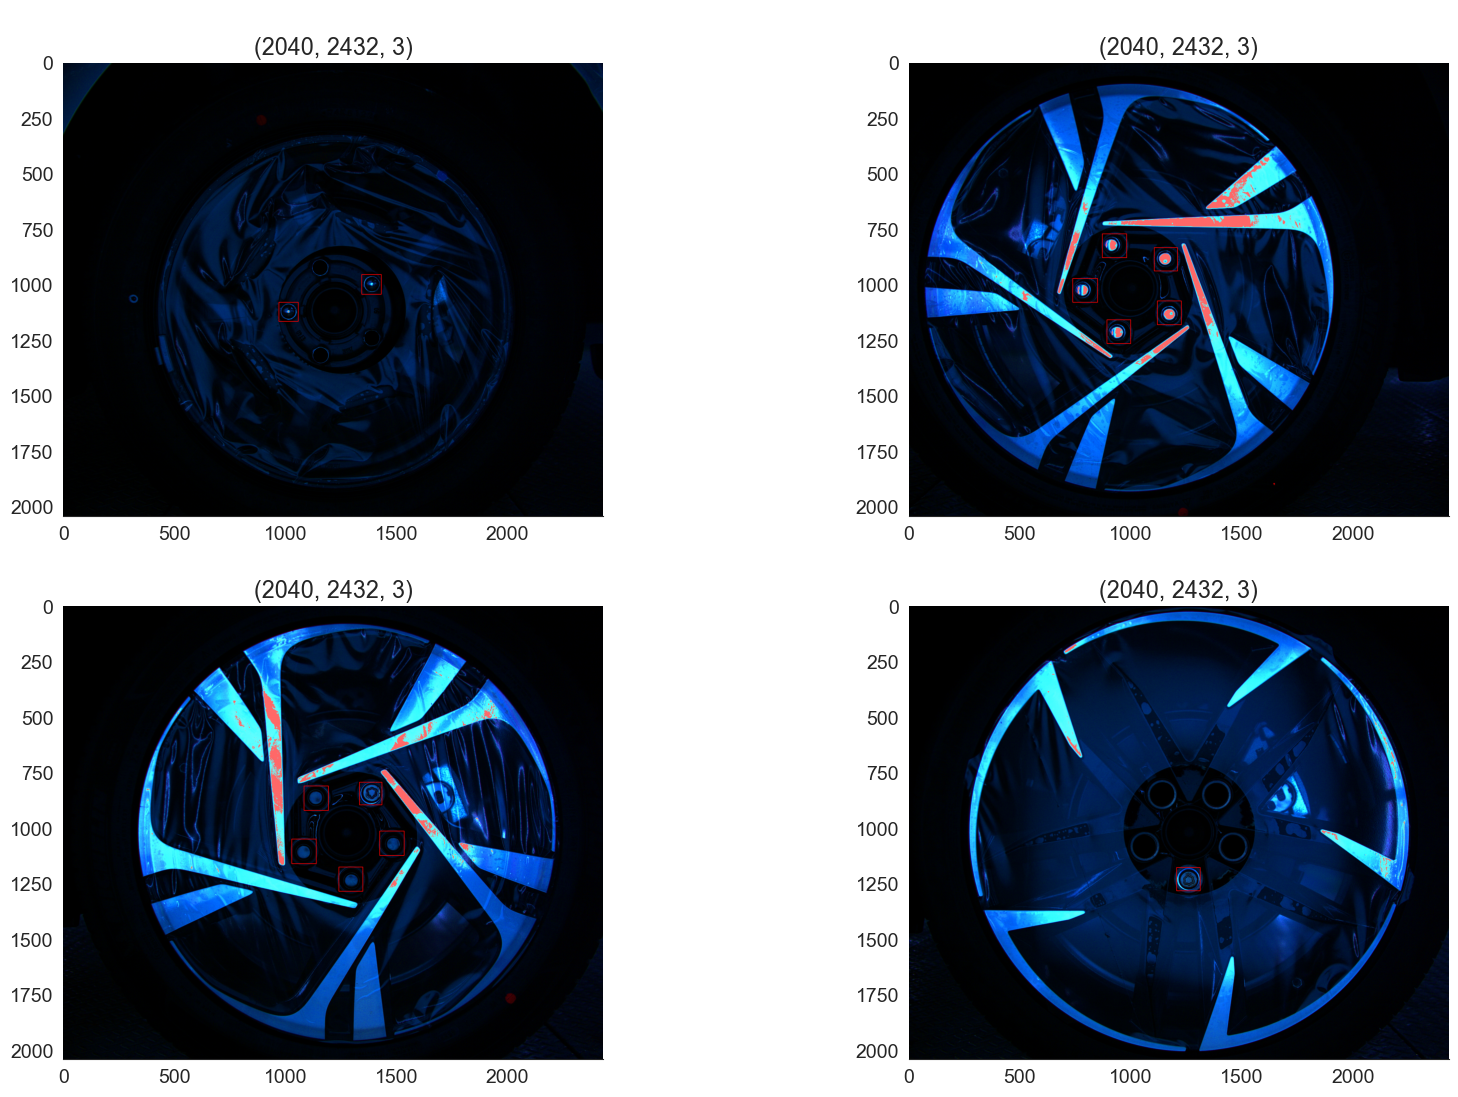

In [20]:
ImageProcess.hsv(x=df["image_path"], bboxes=df['bboxes'], bbox_format="pascal_voc", num_samples=4, plot_gap=10)

In [21]:
def save_processed_images(df=df):
    for i in range(len(df)):
        processed_image = ImageProcess.hsv(np.expand_dims(np.asarray(Image.open(df["image_path"].iloc[i])),axis = 0), sat=120, brt=40, mode="return") 
        processed_image = ImageProcess.solarize(processed_image, tresh=-255, mode="return")        
        ImageProcess.save(x=processed_image, im_size=img_size, im_names=[df["file_name"].iloc[i]])
# save_processed_images()

In [22]:
# # Update Image Paths To New Location
# df['image_path'] = 'dataset/images/' + df['file_name']

In [23]:
def update_bboxes(df=df):
    new_bboxes=[]
    for i in range(len(df)):
        a,bbox,b,c = ImageProcess.just_plot(x=np.expand_dims(np.asarray(Image.open(df["image_path"].iloc[i])),axis = 0), 
                                            bboxes=np.expand_dims(np.asarray(Image.open(df["image_path"].iloc[i])),axis = 0),
                                            im_size=img_size,bbox_format='pascal_voc', mode='return')
        new_bboxes.append(bbox)
    return new_bboxes
#df['bboxes'] = update_bboxes()

# **12. Data Formatting for PyTorch Faster R-CNN**

In [24]:
df["annot_path"] = df["image_path"].agg(lambda x: x.split("bmp")[0]+ 'xml')

# **13. Generate Annotation XMLs If Not Exist (MUST STEP)**

In [25]:
import xml.etree.ElementTree as ET 
from xml.dom import minidom

def GenerateXMLs(annots_dir="./dataset/annots/", df=df):
    """
    This function create xml file for each image in "annots_dir" folder
    annots_dir: Name of the folder to create xmls in "./annots/" format
    df: Dataframe MUST contains following columns:
    • file_name: Image name including format (e.g car13.jpg)
    • bboxes: annotations in pascal voc format: [[xmin,ymin,xmax,ymax][xmin,ymin,xmax,ymax]]
    • label: label for each bbox in this format: [nut, nut, nut]
    """
    
    if not os.path.exists(annots_dir): 
        os.makedirs(annots_dir)
    
    for i, row in enumerate(df["bboxes"]):
    
        xmlname = df["file_name"][i].split(".")[0] + ".xml"
        root = ET.Element("annotation") 

        folder = ET.SubElement(root, "folder") # Create sub element under "root"
        folder.text = "images" # You may change folder name

        filename = ET.SubElement(root, "filename") # Create sub element under "root"
        filename.text = df["file_name"][i]
        
        path = ET.SubElement(root, "path") # Create sub element under "root"
        path.text = df["image_path"][i]
        
        size = ET.Element("size") # Create stackable "size" element
        root.append(size) # Append the element to the root

        width = ET.SubElement(size, "width") # Create sub element under "size"
        width.text = str(Image.open(path.text).size[0])
        height = ET.SubElement(size, "height") # Create sub element under "size"
        height.text = str(Image.open(path.text).size[1])
        depth = ET.SubElement(size, "depth") # Create sub element under "size"
        depth.text = "3"
        
        if len(df["bboxes"][i]) == 0:
            pass
        else:
            for k, bbox in enumerate(df["bboxes"][i]):

                obj = ET.Element("object") # Create stackable "object" element
                root.append(obj) # Append the element to the object

                name = ET.SubElement(obj, "name") # Create sub element under "size"
                name.text = df["label"][i][k]

                bndbox = ET.Element("bndbox")
                obj.append(bndbox)

                xmin = ET.SubElement(bndbox,"xmin")
                xmin.text= str(int(df["bboxes"][i][k][0]))
                ymin = ET.SubElement(bndbox,"ymin")
                ymin.text= str(int(df["bboxes"][i][k][1]))
                xmax = ET.SubElement(bndbox,"xmax")
                xmax.text= str(int(df["bboxes"][i][k][2]))
                ymax = ET.SubElement(bndbox,"ymax")
                ymax.text= str(int(df["bboxes"][i][k][3])) 

        dom = minidom.parseString(ET.tostring(root))
        xml_string = dom.toprettyxml()
        part1, part2 = xml_string.split('?>')
        with open(annots_dir+xmlname, 'w') as xfile:
            xfile.write(part1 + 'encoding=\"{}\"?>\n'.format("UTF-8") + part2)
    print("%s xml files created for %s images" % (i+1, len(df["file_name"])))

# GenerateXMLs("./dataset/annots/", df)

# **14. Create Dataset Class For Faster R-CNN Model**

In [26]:
from fast_dataset import FastRCNN_Dataset

# class FastRCNN_Dataset(torch.utils.data.Dataset):
#     def __init__(self, df, im_size=None, transforms=None):
#         super().__init__()
#         self.df = df
#         self.transforms = transforms
#         self.im_size = im_size
#         # load all image files, sorting them to ensure that they are aligned
#         self.im_paths = df["image_path"].tolist()
#         self.annot_paths = df["annot_path"].tolist()
#         self.labels = df['class'].tolist()
#         self.classes = ['BG'] + sorted(list(set(value for sublist in df['label'] for value in sublist)))
#         self.labels_dict = {c: i+1 for i, c in enumerate(self.classes)}

#     def extract_boxes_from_xml(self, filename):
#         try:
#             tree = ET.parse(filename) # load and parse the file
#         except:
#             return [],[0] # return emptry bbox and BG class if no xml exist
#         root = tree.getroot() # get the root of the document

#         # extract each bounding box
#         boxes,labels = [],[]
#         if len(root.findall('.//bndbox')) == 0:
#             labels.append(0)
#         else:
#             for box in root.findall('object'):
#                 if box.find('name').text == 'OK DS NUT': continue # Skip some class while loading
#                 xmin = int(box.find('bndbox').find('xmin').text)
#                 ymin = int(box.find('bndbox').find('ymin').text)
#                 xmax = int(box.find('bndbox').find('xmax').text)
#                 ymax = int(box.find('bndbox').find('ymax').text)
#                 if xmax > xmin and ymax > ymin:
#                     boxes.append([xmin, ymin, xmax, ymax])
#                     labels.append(self.classes.index(box.find('name').text))
#         return boxes,labels

#     def __getitem__(self, idx):
#         img = Image.open(self.im_paths[idx]).convert("RGB")
#         org_w, org_h = img.size # Original image height,width
#         if self.im_size: img = img.resize(self.im_size)
#         res_w, res_h = img.size # Resized image height,width
#         img = np.array(img, dtype=np.float32) / 255.0
        
#         temp_boxes,labels = self.extract_boxes_from_xml(self.annot_paths[idx]) # get bboxes from xml
#         boxes = []

#         for i,box in enumerate(temp_boxes):
#             if len(box) == 0:
#                 pass
#             else:
#                 if self.im_size:
#                     box[0] = int(box[0]/org_w*res_w)
#                     box[2] = int(box[2]/org_w*res_w)
#                     box[1] = int(box[1]/org_h*res_h)
#                     box[3] = int(box[3]/org_h*res_h)
#                     boxes.append([box[0],box[1],box[2],box[3]])
#                 else:
#                     boxes.append([int(box[0]),int(box[1]),int(box[2]),int(box[3])])
        
#         if self.transforms:
#             aug = self.transforms(image = img, bboxes = [[0,0,20,20]] if len(boxes)==0 else boxes, category_ids = labels)
#             img = aug['image']
#             labels = [0] if len(aug['category_ids']) == 0 else aug['category_ids']
#             if len(boxes)==0 or len(aug['bboxes'])==0:
#                 pass
#             else:
#                 boxes = aug['bboxes']

#         # convert boxes into a Torch Tensors
#         boxes = torch.as_tensor(boxes, dtype=torch.float32)
#         labels = torch.as_tensor(labels, dtype=torch.int64)
        
#         if len(boxes)==0:
#             target = {'boxes': torch.zeros((0, 4), dtype=torch.float32),
#                       'labels': torch.zeros((0,), dtype=torch.int64),
#                       'image_id': torch.tensor([idx]),
#                       'area': torch.zeros((0,), dtype=torch.float32),
#                       'iscrowd': torch.zeros((0,), dtype=torch.int64)}
#         else:
#             target = {'boxes': boxes, 'labels': labels, 'image_id':torch.tensor([idx]), 
#                       'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]), 
#                       'iscrowd': torch.zeros((boxes.shape[0],), dtype=torch.int64)}

#         return torchvision.transforms.ToTensor()(img), target

#     def __len__(self):
#         return len(self.im_paths)

# **15. Confirm Class Loading Image Correctly**

length of dataset =  1334 



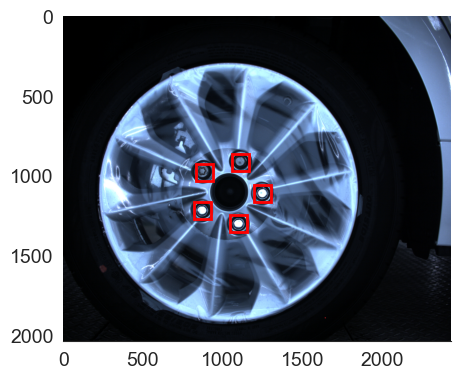

In [27]:
import matplotlib.patches as patches
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img.permute(1, 2, 0)) # permute convert (C, H, W) to (H, W, C)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

deneme = FastRCNN_Dataset(df=df)
print('length of dataset = ', len(deneme), '\n')
img, target = deneme[15]
plot_img_bbox(img, target)

# **16. Splitting Data Into Training, Test & Validation Sets & Create Instances**

In [28]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, shuffle = True, random_state = 8)
train_df, val_df = train_test_split(train_df, test_size=0.25, shuffle = True, random_state = 8)

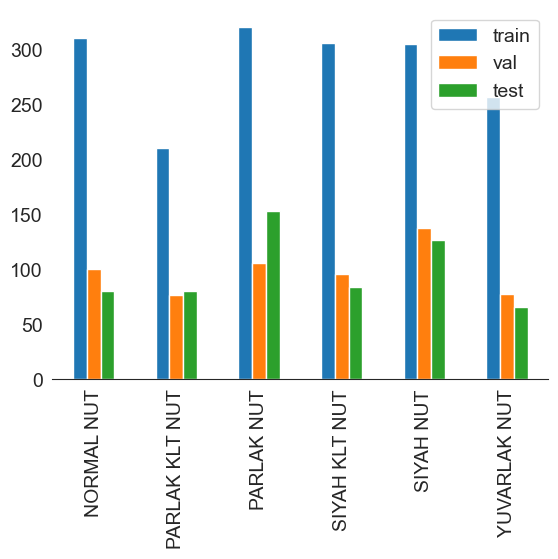

In [29]:
_, train_counts = np.unique(sum(train_df["label"], []), return_counts=True) # sum(train_df["label"], [])
_, val_counts = np.unique(sum(val_df["label"], []), return_counts=True) # sum(val_df["label"], [])
_, test_counts = np.unique(sum(test_df["label"], []), return_counts=True) # sum(test_df["label"], [])

pd.DataFrame({'train': train_counts,'val': val_counts, 'test': test_counts},index=classes[1:]).plot.bar()  
plt.show()

In [30]:
test_set = FastRCNN_Dataset(df=test_df, im_size=img_size)
val_set = FastRCNN_Dataset(df=val_df, im_size=img_size)

# **17. Data Augmentation Of Training Data**

In [31]:
import albumentations as A 

def get_transform(): 
    return A.Compose([ 
        A.SomeOf([ 
            A.Affine(always_apply=False, p=0.5), 
            A.Blur(always_apply=False, p=0.5, blur_limit=(5, 10)), 
            A.ColorJitter(always_apply=False, p=0.5, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  
            A.RandomBrightnessContrast(always_apply=False, p=1.0, brightness_limit=(-0.2, 0.5), contrast_limit=(-0.2, 0.5), brightness_by_max=True),  
            A.ToSepia(always_apply=False, p=0.5) 
        ], 2, replace=False, p=1) 
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids'], min_visibility=0.3)) 

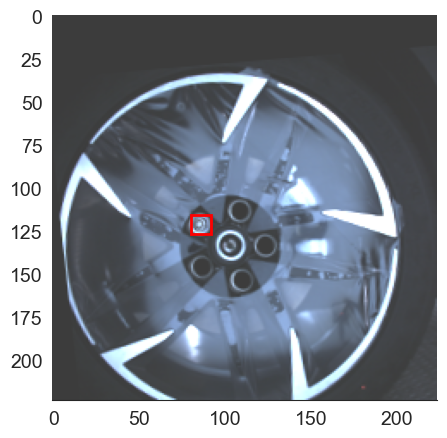

In [32]:
train_set = FastRCNN_Dataset(df=train_df, transforms=get_transform(), im_size=img_size) 
img, target = train_set[17] 
plot_img_bbox(img, target)

# **18. Define Data Loaders**

In [33]:
#collate_fn returns tuples of images and image annotations for every iteration. 
def collate_fn(batch):
    return tuple(zip(*batch)) 

dataloader_train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn) 
dataloader_val = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn) 

# **20. Defining PyTorch Object Detection Model For Training**

In [34]:
def get_model(modelName, pretrained=False, progress=True, num_classes=len(classes), pretrained_backbone=True, trainable_backbone_layers=None): 
    # pretrained=False(default) → If True, returns a model pre-trained on COCO train2017 
    # progress=True(default) → If True, displays a progress bar of the download to stderr 
    # num_classes=91(default) → number of output classes of the model (including the background) 
    # pretrained_backbone=True(default) → If True, returns a model with backbone pre-trained on Imagenet 
    # trainable_backbone_layers=None(default) → Number of trainable (not frozen) resnet layers starting from final block.  
    # Valid values are between 0 and 5, with 5 meaning all backbone layers are trainable.  
    # If None is passed (the default) this value is set to 3. 
    # continue here -Z https://pytorch.org/vision/0.12/models.html 
    # also here -< https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html 
    if modelName == 'fastrcnn_resnet50': 
        # Constructs a Faster R-CNN model with a ResNet-50-FPN backbone. 
        return torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained,progress, num_classes, pretrained_backbone, trainable_backbone_layers) 

    # replace the classifier with a new one, that has num_classes which is user-defined 
    elif modelName == 'fastrcnn_resnet50_finetuned': 
        # Constructs a Faster R-CNN model with a ResNet-50-FPN backbone. 
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained,progress, num_classes, pretrained_backbone, trainable_backbone_layers) 

        # get original number of input features for the classifier head 
        in_features = model.roi_heads.box_predictor.cls_score.in_features 

        # replace the pre-trained head with a new one & adapting number of classes 
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
        return model 

model = get_model(modelName='fastrcnn_resnet50') 

In [35]:
criterion = torch.nn.CrossEntropyLoss() # Define loss function 


# lr=0.0005 | 0.001 | 0.0025 | 0.01
# weight_decay = 0.0005 | 0.005
# optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)
optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad], lr=0.001, momentum=0.9, weight_decay=0.0005)


# Usage: lr_scheduler_ReduceLROnPlateau.step(val_loss)
ReduceLROnPlateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
# Usage: lr_scheduler_StepLR.step() | step_size=2-5
StepLR = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# Usage: lr_scheduler_CosineAnnealingWarmRestarts.step() | T_0=1-3 | T_mult=1-2
CosineAnnealingWarmRestarts = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)

# **21. GPU & CPU Settings**

In [36]:
# If GPU is available, set device to GPU 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

#If there are more than one GPUs, use specific GPUs: 
# model = nn.DataParallel(model, device_ids=[0,1,2,3]) #Remove this line if not necessary. 

# move model to the right device 
model.to(device) 

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

# **24. Empty RAM & Cache Before Training**

In [37]:
import gc
# del df
gc.collect()
torch.cuda.empty_cache()

# **25. Train The Model**

In [38]:
# def calculate_mAP(model, dataloader_val):
#     model.eval()
#     device = next(model.parameters()).device

#     # Define empty lists for storing the ground truth boxes and predicted boxes
#     gt_boxes = []
#     pred_boxes = []

#     with torch.no_grad():
#         for images, targets in dataloader_val:
#             images = list(image.to(device) for image in images)
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#             # Forward pass through the model to get predictions
#             predictions = model(images)

#             for idx, target in enumerate(targets):
#                 # Get the ground truth bounding boxes and labels
#                 gt_boxes.append(target['boxes'].cpu().numpy())

#                 # Get the predicted bounding boxes and labels
#                 pred_boxes.append(predictions[idx]['boxes'].cpu().numpy())

#     # Convert the lists of boxes to numpy arrays
#     gt_boxes = np.concatenate(gt_boxes)
#     pred_boxes = np.concatenate(pred_boxes)

#     # Calculate the Intersection over Union (IoU) between the ground truth and predicted boxes
#     iou = torchvision.ops.box_iou(torch.from_numpy(pred_boxes), torch.from_numpy(gt_boxes))

#     # Calculate the mAP
#     mAP = calculate_mAP_from_iou(iou)

#     return mAP

# def calculate_mAP_from_iou(iou):
#     # Sort the IoU values in descending order
#     sorted_indices = torch.argsort(iou, descending=True)

#     # Initialize variables for calculating precision and recall
#     true_positives = torch.zeros(iou.size(0))
#     false_positives = torch.zeros(iou.size(0))
#     num_gt_boxes = iou.size(1)

#     # Iterate over each predicted box
#     for i in range(iou.size(0)):
#         # Get the indices of the ground truth boxes that have the highest IoU with the predicted box
#         gt_indices = sorted_indices[i]

#         # Check if any of the ground truth boxes have already been detected
#         detected = torch.zeros(num_gt_boxes)

#         # Iterate over each ground truth box
#         for j in range(num_gt_boxes):
#             # Check if the current ground truth box has a high IoU with the predicted box
#             if iou[i, gt_indices[j]] > 0.5:
#                 # If the ground truth box has not been detected yet, consider it as a true positive
#                 if detected[gt_indices[j]] == 0:
#                     true_positives[i] = 1
#                     detected[gt_indices[j]] = 1
#                 # If the ground truth box has been detected before, consider it as a false positive
#                 else:
#                     false_positives[i] = 1

#     # Calculate precision and recall
#     cumulative_true_positives = torch.cumsum(true_positives, dim=0)
#     cumulative_false_positives = torch.cumsum(false_positives, dim=0)
#     cumulative_precision = cumulative_true_positives / (
#             cumulative_true_positives + cumulative_false_positives + 1e-10
#     )
#     cumulative_recall = cumulative_true_positives / num_gt_boxes

#     # Calculate the Average Precision (AP)
#     ap = torch.trapz(cumulative_precision, cumulative_recall)

#     # Calculate the mean Average Precision (mAP)
#     mAP = ap.mean().item()

#     return mAP

In [39]:
import time

In [40]:
# start_time = time.time()  # Get the current time

# num_epochs = 15  # Adjust the number of epochs as needed

# train_losses, classifier_losses, box_reg_losses = [],[],[]
# objectness_losses, rpn_box_reg_losses, mAPs = [],[],[]

# total_train_loss = 0
# best_mAP = 0.0

# for epoch in range(num_epochs):
#     model.train() # Set the model to training model
    
#     train_loss,classifier_loss,box_reg_loss,objectness_loss,rpn_box_reg_loss,counter = 0.0,0.0,0.0,0.0,0.0,0
    
#     for images, targets in dataloader_train:
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
#         outputs = model(images, targets)  # Forward pass
        
#         classifier_loss += outputs['loss_classifier'].tolist()
#         box_reg_loss += outputs['loss_box_reg'].tolist()
#         objectness_loss += outputs['loss_objectness'].tolist()
#         rpn_box_reg_loss += outputs['loss_rpn_box_reg'].tolist()
#         counter += 1
        
#         losses = sum(loss for loss in outputs.values())
#         train_loss += losses.item()
        
#         optimizer.zero_grad()  # Optimization
#         losses.backward()  # Backward propagation and optimization
#         optimizer.step()  # Updating parameters
    
#     train_losses.append(train_loss/counter)
#     classifier_losses.append(classifier_loss/counter)
#     box_reg_losses.append(box_reg_loss/counter)
#     objectness_losses.append(objectness_loss/counter)
#     rpn_box_reg_losses.append(rpn_box_reg_loss/counter)
    
#     model.eval()
#     mAP = calculate_mAP(model=model, dataloader_val=dataloader_val)
#     mAPs.append(mAP)
    
#     StepLR.step()
    
#     if mAP > best_mAP:
#         best_mAP = mAP
#         torch.save(model.state_dict(), f'best_model.pt')
#         print(f"mAP improved to {best_mAP:.4f}. Saving model...")
        
#     print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_losses[-1]:.4f}, "
#           f"Classifier Loss: {classifier_losses[-1]:.4f}, Box Reg Loss: {box_reg_losses[-1]:.4f}, "
#           f"Objectness Loss: {objectness_losses[-1]:.4f}, RPN Box Reg Loss: {rpn_box_reg_losses[-1]:.4f}, mAP: {mAP:.4f}")
    
# end_time = time.time()  # Get the current time again
# execution_time = end_time - start_time  # Calculate the execution time

# print(f"Execution time: {execution_time} seconds")
# # 15 epochs | best_map:21.04, Train Loss: 0.2501, Classifier Loss: 0.1104, Box Reg Loss: 0.1233, Objectness Loss: 0.0105, RPN Box Reg Loss: 0.0059, mAP: 13.2235 - 1748 seconds

In [41]:
start_time = time.time()  # Get the current time

num_epochs = 15
train_losses, classifier_losses, box_reg_losses = [],[],[]
objectness_losses, rpn_box_reg_losses, mAPs = [],[],[]
best_mAP = 0

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    # training for one epoch
    metric_logger = train_one_epoch(model, optimizer, dataloader_train, device, epoch, print_freq=10)

    if metric_logger.meters['loss'].count != 0:
        train_losses.append(metric_logger.meters['loss'].global_avg)
    if metric_logger.meters['loss_classifier'].count != 0:
        classifier_losses.append(metric_logger.meters['loss_classifier'].global_avg)
    if metric_logger.meters['loss_box_reg'].count != 0:
        box_reg_losses.append(metric_logger.meters['loss_box_reg'].global_avg)
    if metric_logger.meters['loss_objectness'].count != 0:
        objectness_losses.append(metric_logger.meters['loss_objectness'].global_avg)
    if metric_logger.meters['loss_rpn_box_reg'].count != 0:
        rpn_box_reg_losses.append(metric_logger.meters['loss_rpn_box_reg'].global_avg)

    # evaluate on the validation dataset and get the mAP value
    coco_evaluator = evaluate(model, dataloader_val, device=device)
    mAP = coco_evaluator.coco_eval['bbox'].stats[0]
    mAPs.append(mAP)
    
    StepLR.step()
    
    if mAP > best_mAP:
        best_mAP = mAP
        torch.save(model.state_dict(), f'best_model.pt')
        print(f"mAP improved to {best_mAP:.4f}. Saving model...")
        
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_losses[-1]:.4f}, "
          f"Classifier Loss: {classifier_losses[-1]:.4f}, Box Reg Loss: {box_reg_losses[-1]:.4f}, "
          f"Objectness Loss: {objectness_losses[-1]:.4f}, RPN Box Reg Loss: {rpn_box_reg_losses[-1]:.4f}, mAP: {mAP:.4f}")
    
end_time = time.time()  # Get the current time again
execution_time = end_time - start_time  # Calculate the execution time

print(f"Execution time: {execution_time} seconds")
# 15 epochs | best_map:26.04, Train Loss: 0.2446, Classifier Loss: 0.1060, Box Reg Loss: 0.1224, Objectness Loss: 0.0110, RPN Box Reg Loss: 0.0052, mAP: 0.2627 - 2486 seconds

Epoch 0/14
----------
Epoch: [0]  [  0/100]  eta: 0:04:50  lr: 0.000011  loss: 2.6494 (2.6494)  loss_classifier: 1.9155 (1.9155)  loss_box_reg: 0.0235 (0.0235)  loss_objectness: 0.6920 (0.6920)  loss_rpn_box_reg: 0.0184 (0.0184)  time: 2.9099  data: 0.2895  max mem: 5770
Epoch: [0]  [ 10/100]  eta: 0:01:27  lr: 0.000112  loss: 2.6047 (2.5878)  loss_classifier: 1.8997 (1.8773)  loss_box_reg: 0.0115 (0.0107)  loss_objectness: 0.6911 (0.6912)  loss_rpn_box_reg: 0.0083 (0.0085)  time: 0.9692  data: 0.3063  max mem: 5929
Epoch: [0]  [ 20/100]  eta: 0:01:13  lr: 0.000213  loss: 2.4816 (2.4109)  loss_classifier: 1.7492 (1.7005)  loss_box_reg: 0.0107 (0.0116)  loss_objectness: 0.6897 (0.6881)  loss_rpn_box_reg: 0.0098 (0.0108)  time: 0.8244  data: 0.3077  max mem: 5929
Epoch: [0]  [ 30/100]  eta: 0:01:03  lr: 0.000314  loss: 1.7870 (2.0863)  loss_classifier: 1.0974 (1.3898)  loss_box_reg: 0.0077 (0.0102)  loss_objectness: 0.6758 (0.6759)  loss_rpn_box_reg: 0.0104 (0.0104)  time: 0.8729  data: 

mAP improved to 0.0999. Saving model...
Epoch 2/15: Train Loss: 0.3418, Classifier Loss: 0.1676, Box Reg Loss: 0.1365, Objectness Loss: 0.0315, RPN Box Reg Loss: 0.0062, mAP: 0.0999
Epoch 2/14
----------
Epoch: [2]  [  0/100]  eta: 0:01:27  lr: 0.001000  loss: 0.1977 (0.1977)  loss_classifier: 0.0971 (0.0971)  loss_box_reg: 0.0792 (0.0792)  loss_objectness: 0.0152 (0.0152)  loss_rpn_box_reg: 0.0062 (0.0062)  time: 0.8782  data: 0.3137  max mem: 5930
Epoch: [2]  [ 10/100]  eta: 0:01:18  lr: 0.001000  loss: 0.3084 (0.2915)  loss_classifier: 0.1432 (0.1348)  loss_box_reg: 0.1442 (0.1312)  loss_objectness: 0.0171 (0.0194)  loss_rpn_box_reg: 0.0062 (0.0061)  time: 0.8731  data: 0.3116  max mem: 5930
Epoch: [2]  [ 20/100]  eta: 0:01:09  lr: 0.001000  loss: 0.3084 (0.3048)  loss_classifier: 0.1432 (0.1428)  loss_box_reg: 0.1294 (0.1366)  loss_objectness: 0.0175 (0.0194)  loss_rpn_box_reg: 0.0054 (0.0060)  time: 0.8694  data: 0.3079  max mem: 5930
Epoch: [2]  [ 30/100]  eta: 0:01:01  lr: 0.001

mAP improved to 0.2380. Saving model...
Epoch 4/15: Train Loss: 0.2726, Classifier Loss: 0.1273, Box Reg Loss: 0.1270, Objectness Loss: 0.0131, RPN Box Reg Loss: 0.0052, mAP: 0.2380
Epoch 4/14
----------
Epoch: [4]  [  0/100]  eta: 0:01:27  lr: 0.000100  loss: 0.2584 (0.2584)  loss_classifier: 0.1270 (0.1270)  loss_box_reg: 0.1215 (0.1215)  loss_objectness: 0.0057 (0.0057)  loss_rpn_box_reg: 0.0041 (0.0041)  time: 0.8785  data: 0.3137  max mem: 5930
Epoch: [4]  [ 10/100]  eta: 0:01:18  lr: 0.000100  loss: 0.2584 (0.2561)  loss_classifier: 0.1187 (0.1167)  loss_box_reg: 0.1171 (0.1229)  loss_objectness: 0.0091 (0.0118)  loss_rpn_box_reg: 0.0041 (0.0047)  time: 0.8772  data: 0.3080  max mem: 5930
Epoch: [4]  [ 20/100]  eta: 0:01:10  lr: 0.000100  loss: 0.2635 (0.2668)  loss_classifier: 0.1187 (0.1226)  loss_box_reg: 0.1171 (0.1279)  loss_objectness: 0.0088 (0.0112)  loss_rpn_box_reg: 0.0041 (0.0050)  time: 0.8779  data: 0.3083  max mem: 5930
Epoch: [4]  [ 30/100]  eta: 0:01:01  lr: 0.000

Epoch: [6]  [  0/100]  eta: 0:01:27  lr: 0.000010  loss: 0.1652 (0.1652)  loss_classifier: 0.0650 (0.0650)  loss_box_reg: 0.0925 (0.0925)  loss_objectness: 0.0021 (0.0021)  loss_rpn_box_reg: 0.0056 (0.0056)  time: 0.8786  data: 0.2981  max mem: 5930
Epoch: [6]  [ 10/100]  eta: 0:01:20  lr: 0.000010  loss: 0.2394 (0.2471)  loss_classifier: 0.1027 (0.1068)  loss_box_reg: 0.1245 (0.1248)  loss_objectness: 0.0069 (0.0088)  loss_rpn_box_reg: 0.0064 (0.0067)  time: 0.8990  data: 0.3160  max mem: 5930
Epoch: [6]  [ 20/100]  eta: 0:01:11  lr: 0.000010  loss: 0.2394 (0.2416)  loss_classifier: 0.1027 (0.1056)  loss_box_reg: 0.1245 (0.1199)  loss_objectness: 0.0074 (0.0099)  loss_rpn_box_reg: 0.0056 (0.0063)  time: 0.8958  data: 0.3140  max mem: 5930
Epoch: [6]  [ 30/100]  eta: 0:01:02  lr: 0.000010  loss: 0.2289 (0.2428)  loss_classifier: 0.0952 (0.1047)  loss_box_reg: 0.1250 (0.1221)  loss_objectness: 0.0091 (0.0101)  loss_rpn_box_reg: 0.0049 (0.0059)  time: 0.8862  data: 0.3124  max mem: 5930


Epoch: [8]  [  0/100]  eta: 0:01:26  lr: 0.000010  loss: 0.2376 (0.2376)  loss_classifier: 0.0898 (0.0898)  loss_box_reg: 0.1306 (0.1306)  loss_objectness: 0.0121 (0.0121)  loss_rpn_box_reg: 0.0051 (0.0051)  time: 0.8621  data: 0.2987  max mem: 5930
Epoch: [8]  [ 10/100]  eta: 0:01:18  lr: 0.000010  loss: 0.2254 (0.2545)  loss_classifier: 0.0938 (0.1108)  loss_box_reg: 0.1188 (0.1272)  loss_objectness: 0.0113 (0.0115)  loss_rpn_box_reg: 0.0043 (0.0051)  time: 0.8714  data: 0.3048  max mem: 5930
Epoch: [8]  [ 20/100]  eta: 0:01:09  lr: 0.000010  loss: 0.2254 (0.2280)  loss_classifier: 0.0947 (0.1002)  loss_box_reg: 0.1088 (0.1132)  loss_objectness: 0.0062 (0.0103)  loss_rpn_box_reg: 0.0038 (0.0043)  time: 0.8699  data: 0.3054  max mem: 5930
Epoch: [8]  [ 30/100]  eta: 0:01:00  lr: 0.000010  loss: 0.2649 (0.2453)  loss_classifier: 0.1227 (0.1070)  loss_box_reg: 0.1303 (0.1222)  loss_objectness: 0.0079 (0.0112)  loss_rpn_box_reg: 0.0045 (0.0049)  time: 0.8691  data: 0.3057  max mem: 5930


Epoch: [10]  [  0/100]  eta: 0:01:25  lr: 0.000001  loss: 0.2261 (0.2261)  loss_classifier: 0.0996 (0.0996)  loss_box_reg: 0.1057 (0.1057)  loss_objectness: 0.0144 (0.0144)  loss_rpn_box_reg: 0.0064 (0.0064)  time: 0.8538  data: 0.2981  max mem: 5930
Epoch: [10]  [ 10/100]  eta: 0:01:18  lr: 0.000001  loss: 0.2261 (0.2290)  loss_classifier: 0.0918 (0.0987)  loss_box_reg: 0.1063 (0.1142)  loss_objectness: 0.0106 (0.0118)  loss_rpn_box_reg: 0.0042 (0.0043)  time: 0.8686  data: 0.3071  max mem: 5930
Epoch: [10]  [ 20/100]  eta: 0:01:09  lr: 0.000001  loss: 0.1994 (0.2149)  loss_classifier: 0.0878 (0.0942)  loss_box_reg: 0.1013 (0.1069)  loss_objectness: 0.0084 (0.0096)  loss_rpn_box_reg: 0.0042 (0.0043)  time: 0.8720  data: 0.3083  max mem: 5930
Epoch: [10]  [ 30/100]  eta: 0:01:00  lr: 0.000001  loss: 0.2389 (0.2357)  loss_classifier: 0.1039 (0.1025)  loss_box_reg: 0.1200 (0.1187)  loss_objectness: 0.0084 (0.0097)  loss_rpn_box_reg: 0.0045 (0.0048)  time: 0.8713  data: 0.3058  max mem: 5

Epoch: [12]  [  0/100]  eta: 0:01:27  lr: 0.000000  loss: 0.2419 (0.2419)  loss_classifier: 0.1054 (0.1054)  loss_box_reg: 0.1232 (0.1232)  loss_objectness: 0.0069 (0.0069)  loss_rpn_box_reg: 0.0064 (0.0064)  time: 0.8746  data: 0.3256  max mem: 5930
Epoch: [12]  [ 10/100]  eta: 0:01:18  lr: 0.000000  loss: 0.2669 (0.2613)  loss_classifier: 0.1068 (0.1135)  loss_box_reg: 0.1306 (0.1301)  loss_objectness: 0.0078 (0.0108)  loss_rpn_box_reg: 0.0064 (0.0069)  time: 0.8768  data: 0.3118  max mem: 5930
Epoch: [12]  [ 20/100]  eta: 0:01:10  lr: 0.000000  loss: 0.2669 (0.2637)  loss_classifier: 0.1068 (0.1131)  loss_box_reg: 0.1306 (0.1317)  loss_objectness: 0.0099 (0.0126)  loss_rpn_box_reg: 0.0053 (0.0064)  time: 0.8778  data: 0.3121  max mem: 5930
Epoch: [12]  [ 30/100]  eta: 0:01:01  lr: 0.000000  loss: 0.2301 (0.2532)  loss_classifier: 0.0972 (0.1089)  loss_box_reg: 0.1221 (0.1267)  loss_objectness: 0.0064 (0.0116)  loss_rpn_box_reg: 0.0048 (0.0059)  time: 0.8770  data: 0.3118  max mem: 5

Epoch: [14]  [  0/100]  eta: 0:01:27  lr: 0.000000  loss: 0.2446 (0.2446)  loss_classifier: 0.1155 (0.1155)  loss_box_reg: 0.1191 (0.1191)  loss_objectness: 0.0040 (0.0040)  loss_rpn_box_reg: 0.0059 (0.0059)  time: 0.8786  data: 0.3141  max mem: 5930
Epoch: [14]  [ 10/100]  eta: 0:01:18  lr: 0.000000  loss: 0.2171 (0.1984)  loss_classifier: 0.1024 (0.0881)  loss_box_reg: 0.1036 (0.0992)  loss_objectness: 0.0052 (0.0069)  loss_rpn_box_reg: 0.0037 (0.0042)  time: 0.8706  data: 0.3069  max mem: 5930
Epoch: [14]  [ 20/100]  eta: 0:01:09  lr: 0.000000  loss: 0.2241 (0.2362)  loss_classifier: 0.1042 (0.1052)  loss_box_reg: 0.1113 (0.1176)  loss_objectness: 0.0066 (0.0084)  loss_rpn_box_reg: 0.0041 (0.0051)  time: 0.8734  data: 0.3107  max mem: 5930
Epoch: [14]  [ 30/100]  eta: 0:01:01  lr: 0.000000  loss: 0.2682 (0.2382)  loss_classifier: 0.1051 (0.1057)  loss_box_reg: 0.1281 (0.1181)  loss_objectness: 0.0080 (0.0095)  loss_rpn_box_reg: 0.0052 (0.0049)  time: 0.8761  data: 0.3127  max mem: 5

# **26. Evaluate Model's Performance**

### **26.1 Evaluate Model's Performance**

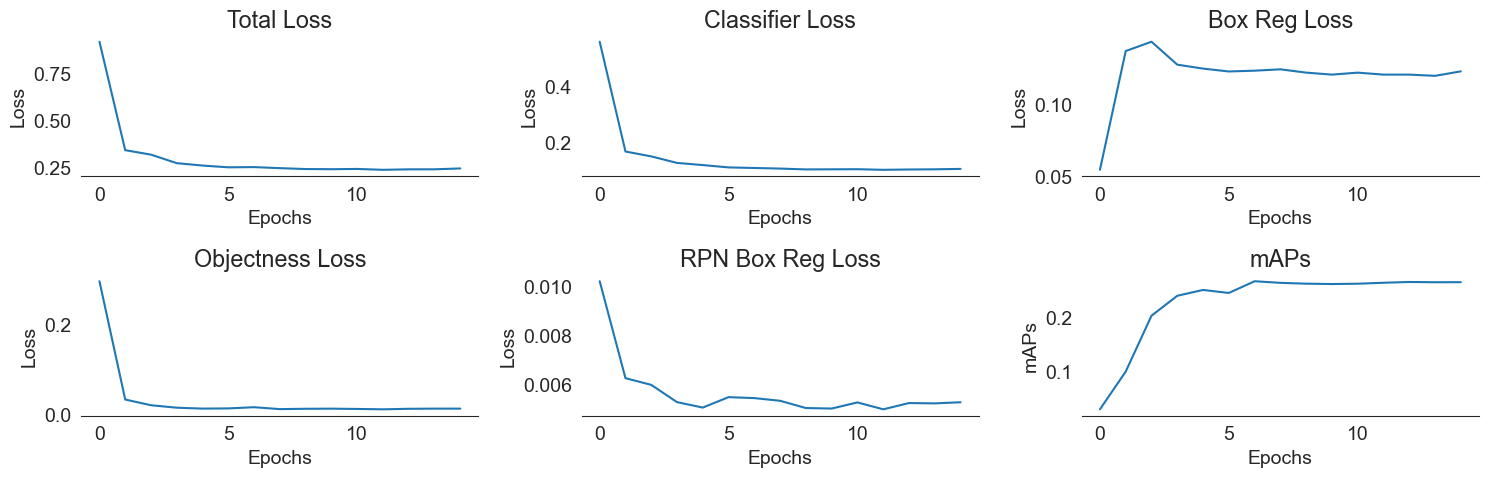

In [42]:
# plot the loss curves
plt.figure(figsize=(15,5))

plt.subplot(2, 3, 1)
plt.plot(train_losses)
plt.title("Total Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2, 3, 2)
plt.plot(classifier_losses)
plt.title("Classifier Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2, 3, 3)
plt.plot(box_reg_losses)
plt.title("Box Reg Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2, 3, 4)
plt.plot(objectness_losses)
plt.title("Objectness Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2, 3, 5)
plt.plot(rpn_box_reg_losses)
plt.title("RPN Box Reg Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2, 3, 6)
plt.plot(mAPs)
plt.title("mAPs")
plt.xlabel('Epochs')
plt.ylabel('mAPs')

plt.tight_layout()
plt.show()

### **26.2 Load Best Model Weights**

In [45]:
model = get_model(modelName='fastrcnn_resnet50') 
#device = torch.device('cpu')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load('best_model.pt', map_location=device))
model.to(device)
# set the model to evaluation mode
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

### **26.3 Show Some Predictions**

In [52]:
def apply_nms(prediction, threshold=0.001):
    # torchvision returns the indices of the boxes to keep
    keep = torchvision.ops.nms(prediction['boxes'], prediction['scores'], threshold)
    
    final_prediction = prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

def show_torchbox_predictions(num_samples = 5, num_cols = 3, plot_gap = 3, threshold=0.001):
    plt.figure(figsize=(20,num_samples*plot_gap)) # Increase plot_gap if images nested together
    for i,idx in enumerate(random.sample(range(len(test_set.im_paths)), num_samples)):
        img, target = test_set[idx]

        # Prediction with model
        with torch.no_grad():
            prediction = model([img.to(device)])[0]

        img = np.ascontiguousarray(img.permute(1, 2, 0))

        nms_applied_pred = apply_nms(prediction, threshold)
        plt.subplot(int(num_samples/num_cols)+1,num_cols,i+1)
        for k, box in enumerate(nms_applied_pred['boxes']):
            [x1,y1,x2,y2]  = box
            [x1,y1,x2,y2] = [int(x) for x in [x1,y1,x2,y2]]
            cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)
            cv2.putText(img, le.inverse_transform([int(nms_applied_pred['labels'][k])])[0], (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 2/4, (255,0,0), 2)
        plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

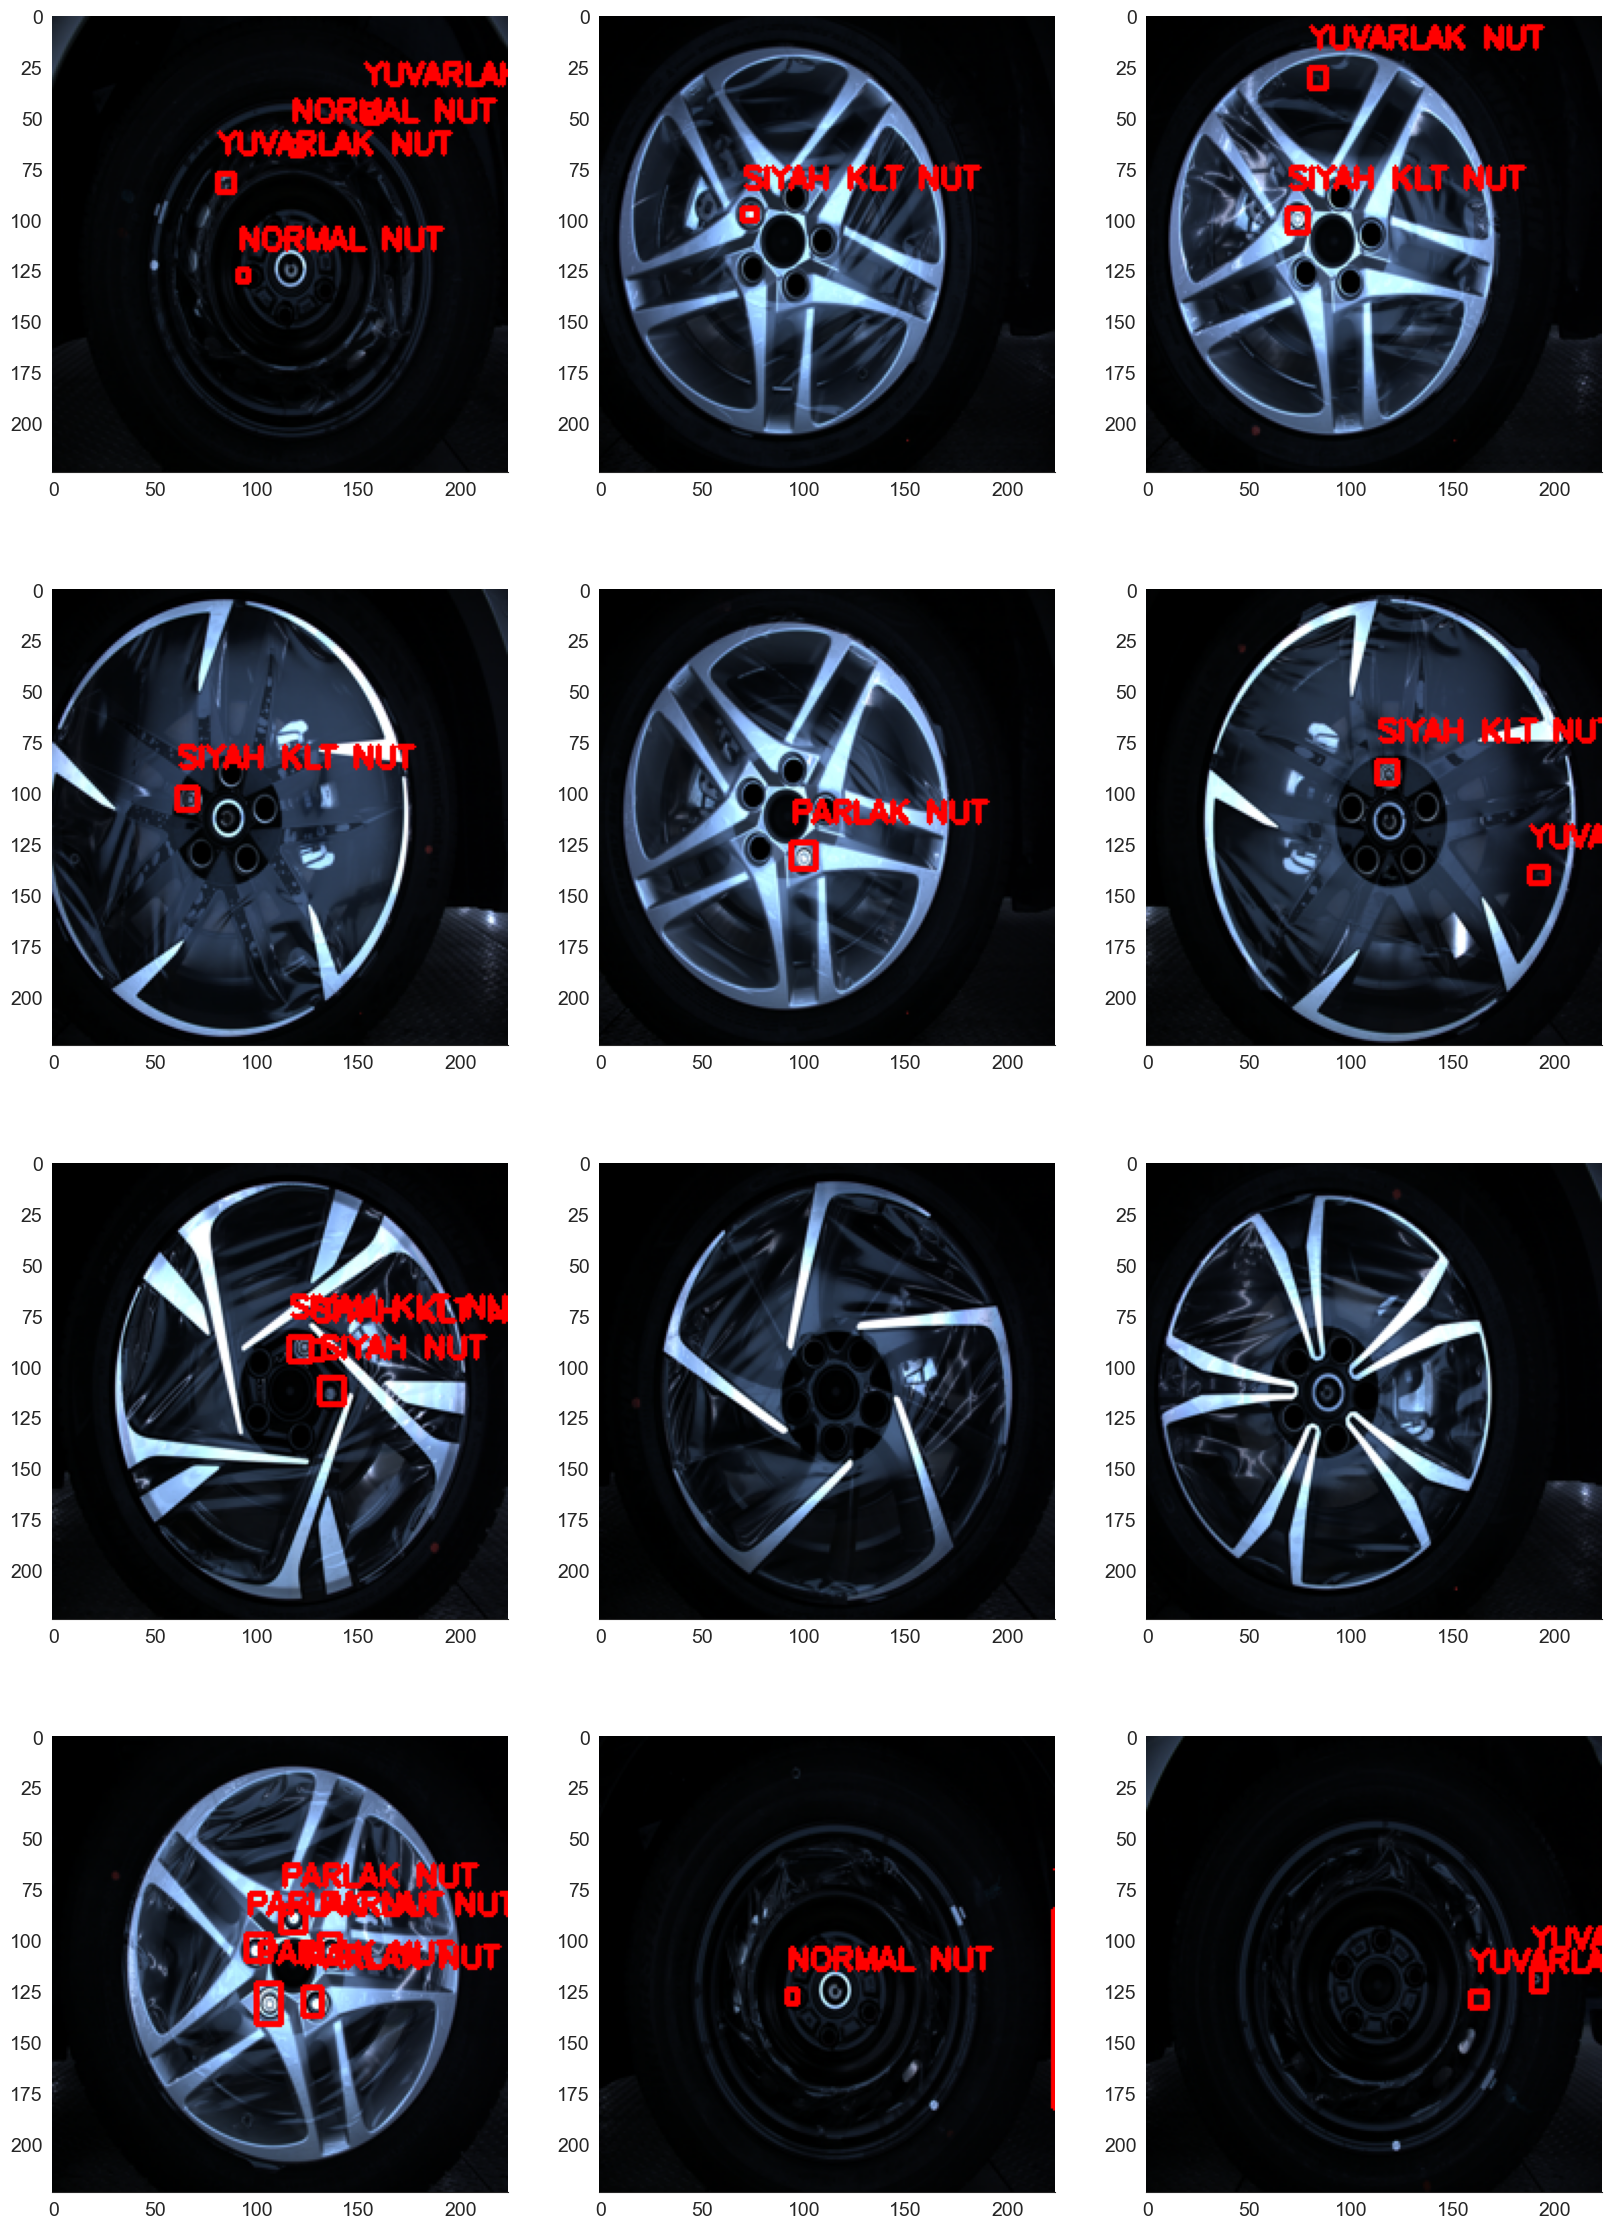

In [54]:
show_torchbox_predictions(num_samples = 12, threshold=0.0001)

# **FASTER R_CNN INFERENCE**

# **28. Loading Model From File & GPU / CPU Settings**

In [50]:
model = get_model(modelName='fastrcnn_resnet50') 
#device = torch.device('cpu')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load('best_model.pt', map_location=device))
model.to(device)
# set the model to evaluation mode
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

# **29. Load Class Dictionary**

In [ ]:
le = joblib.load("Hubnut_Detection_FasterRCNN_Label_Encoder.joblib") 

# **30. Predictions**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 2000x300 with 0 Axes>

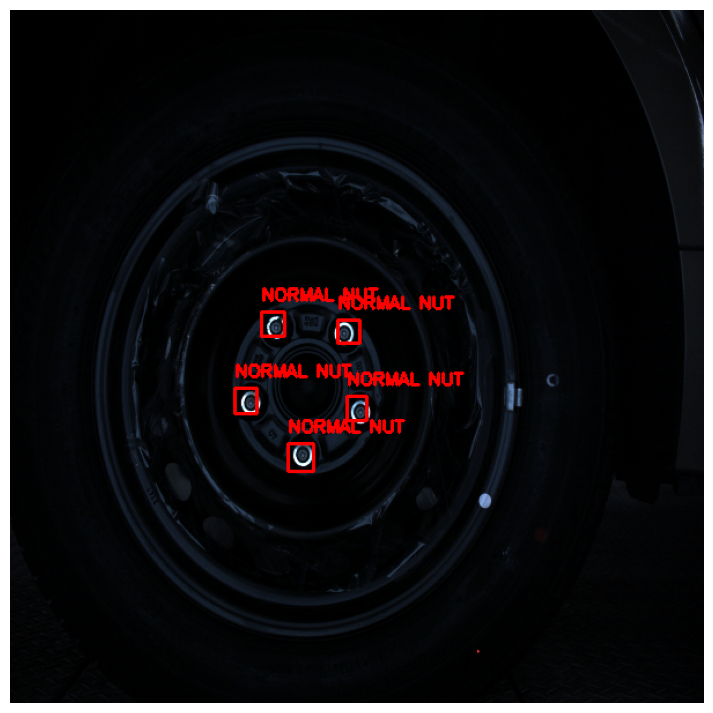

In [56]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image

def apply_nms(prediction, threshold=0.001):
    # torchvision returns the indices of the boxes to keep
    keep = torchvision.ops.nms(prediction['boxes'], prediction['scores'], threshold)
    
    final_prediction = prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

def show_torchbox_predictions(image_path, num_samples = 1, num_cols = 1, plot_gap = 3, threshold=0.0001, im_size=None):
    plt.figure(figsize=(20,num_samples*plot_gap)) # Increase plot_gap if images nested together
    for i in range(num_samples):
        img = Image.open(image_path).convert('RGB')
        img = cv2.resize(np.asarray(img),im_size) if im_size is not None else img
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        img = transform(img)

        # Prediction with model
        with torch.no_grad():
            prediction = model([img.to(device)])[0]
        img = np.ascontiguousarray(img.permute(1, 2, 0))

        nms_applied_pred = apply_nms(prediction, threshold)
        plt.figure(figsize=(20,9))
        for k, box in enumerate(nms_applied_pred['boxes']):
            [x1,y1,x2,y2]  = box
            [x1,y1,x2,y2] = [int(x) for x in [x1,y1,x2,y2]]
            cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)
            cv2.putText(img, le.inverse_transform([int(nms_applied_pred['labels'][k].item())])[0], (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 2/4, (255,0,0), 2)

        # Show the image
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
show_torchbox_predictions('../../datasets//TMMT Hubnut Object Detection Dataset//BEY//40188_STD_BEY_5NORYOK - PRED_SAR_5NORYOK 1.bmp', im_size=(600,600))